# Supplemental Notebook for Manuscript
### Input data:
This notebook reads RBN metadata stored in folders `Results20`, `Results50`, `Results100`, and `Results200`, which are merged and stored in `full_RBN_data.csv` with some preprocessing.
Cell Collective network data is also read from the `cc_network_data.csv` file.

The RBN results can be generated using the `PowerLaw_Experiment.py` script. Cell Collective summary data can be generated using the `cc_analysis.py` script.

### Analysis and requirements:
All figures from the accompanying manuscript are reproducible by running this notebook. Additional figures are also produced here to supplement the main text.
This notebook require `panda`, `numpy`, `sklearn`, `scipy`, and `matplotlib` to be installed.

#### We begin by importing various libraries and functions we will need for the analysis.

In [1]:
import pandas as pd
import numpy as np

import itertools

from os import listdir

from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from scipy import stats, special

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import CenteredNorm
%matplotlib inline

#### Next, we define various helper functions for preprocessing the data we will import.

In [2]:
def merge_results_frames(df,df2):
    for idx,r in df.iterrows():
        g = r['gamma']
        p = r['bias']
        for col in df.columns:
            if col == 'gamma' or col == 'bias':
                continue
            df.loc[(df['gamma']==g) & (df['bias']==p),col]+=df2.loc[(df2['gamma']==g) & (df2['bias']==p),col]

def str2list(strarray):
    return [float(x) for x in strarray.strip('[] ').split()]

def df_str2list(df):
    for col in df.columns:
        if col == 'gamma' or col == 'bias':
            continue
        df[col] = df[col].apply(str2list)

def expand_shared_properties_in_dict(df):
    dictall = {}
    for _,row in df.iterrows():
        for col in df.columns:
            if col in ['gamma','bias']:
                rowlist = [row[col]]*len(row['Derrida'])
            else:
                rowlist = row[col]
            if col in dictall:
                dictall[col] += rowlist
            else:
                dictall[col] = rowlist.copy()
    return dictall

def append_extra_columns(dictall):
    dfall = pd.DataFrame(dictall)

    dfall['entropy'] = -(dfall['bias']*np.log2(dfall['bias']))-((1-dfall['bias'])*np.log2(1-dfall['bias']))
    dfall['variance'] = dfall['bias']*(1-dfall['bias'])

    
    dfall['regime']=(dfall['Derrida']>1).astype(int) - (dfall['Derrida']<1).astype(int)
    dfall['avgS']=dfall['avgKe']-dfall['avgKc']
    dfall['avgH'] = -dfall['avgP']*np.log2(dfall['avgP'])-(1-dfall['avgP'])*np.log2(1-dfall['avgP'])
    dfall['avgV'] = (1-dfall['avgP'])*dfall['avgP']
    
    return dfall

#### We now import the RBN data.
Note that the variable `REGENERATE_DATA` determines whether the data will be read from the individual results folder to create a new `full_RBN_data.csv` file (if `True`) or read from from a previously assembled `full_RBN_data.csv` file (if `False`).

In [3]:
REGENERATE_DATA=True # takes a couple of minutes to regenerate data frame from individual csv files

results_dir_dict={20:'Results20/',50:'Results50/',100:'Results100/',200:'Results200/'}
if REGENERATE_DATA:
    dfall = pd.DataFrame()
    for N,results_dir in results_dir_dict.items():
        first_in_N = True
        for filename in listdir(results_dir):
            if first_in_N:
                df = pd.read_csv(results_dir+filename)
                df_str2list(df)
                first_in_N = False
            else:
                df2 = pd.read_csv(results_dir+filename)
                df_str2list(df2)
                merge_results_frames(df,df2)
        dictall = expand_shared_properties_in_dict(df)
        dfallN = append_extra_columns(dictall)
        dfallN['N']=N
        dfall = pd.concat([dfall,dfallN],axis=0)
    dfall.to_csv('full_RBN_data.csv')           
else:
    dfall=pd.read_csv('full_RBN_data.csv')
Nvals = results_dir_dict.keys()
dfall['gamma'] = dfall['gamma'].round(2) # to fix some entries recorded, e.g., like 2.100000005
dfall['bias'] = dfall['bias'].round(2)
# shuffle data
dfall=dfall.sample(frac=1.0)

dfall

c:\Users\jcroz\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jcroz\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


gamma  bias  Derrida  avgK  medK     avgKe  medKe     avgKc  medKc  \
15651    1.9  0.20    0.783  2.44   2.0  1.236243    1.0  0.425593    0.0   
7546     1.7  0.05    0.257  2.40   1.0  0.654487    0.0  0.424280    0.0   
13718    1.8  0.40    1.041  2.08   1.0  1.303416    1.0  0.269920    0.0   
12438    1.8  0.25    0.976  2.80   2.0  1.403646    1.0  0.506454    0.0   
18018    2.0  0.05    0.237  2.23   1.0  0.612845    0.0  0.363412    0.0   
...      ...   ...      ...   ...   ...       ...    ...       ...    ...   
22097    2.1  0.10    0.305  2.45   1.0  0.777315    0.0  0.483369    0.0   
6847     1.6  0.45    1.296  2.63   2.0  1.707408    1.0  0.431909    0.0   
1872     1.5  0.25    1.072  2.88   2.0  1.680402    1.0  0.595546    0.0   
9648     1.7  0.35    1.266  2.79   1.0  1.794148    1.0  0.546008    0.0   
13807    1.8  0.40    1.330  2.88   1.0  1.926674    1.0  0.555920    0.0   

           avgP   entropy  variance  regime      avgS      avgH      avgV    N  
15651  0.194875  0.721928    0.1600      -1  0.810649  0.711559  0.156899  100  
7546   0.050495  0.286397    0.0475      -1  0.230208  0.288494  0.047945  200  
13718  0.403880  0.970951    0.2400       1  1.033496  0.973175  0.240761  100  
12438  0.251318  0.811278    0.1875      -1  0.897192  0.813360  0.188157   20  
18018  0.049953  0.286397    0.0475      -1  0.249434  0.286197  0.047458  100  
...         ...       ...       ...     ...       ...       ...       ...  ...  
22097  0.093705  0.468996    0.0900      -1  0.293945  0.448718  0.084925   20  
6847   0.448777  0.992774    0.2475       1  1.275498  0.992416  0.247376  200  
1872   0.251527  0.811278    0.1875       1  1.084857  0.813690  0.188261  100  
9648   0.352526  0.934068    0.2275       1  1.248140  0.936303  0.228251  100  
13807  0.397513  0.970951    0.2400       1  1.370754  0.969477  0.239496  200  

[144000 rows x 17 columns]

#### We define a helper function for finding the critical boundary.
The thermodynamic critical boundary depends upon the average in-degree. We therefore define a function to calculate this mean (in the thermodynamic limit) from the generateing parameter `gamma` ($\gamma$) assuming a truncated power-law distribution with exponent $\gamma$ and cutoff $m$ (here explicitly called `cutoff`).

In [4]:
def kmean(gamma,cutoff=None):
    if cutoff is None:
        return special.zeta(gamma-1)/special.zeta(gamma)
    else:
        ks = np.arange(1,cutoff+1).astype(float)
        return np.sum(ks**(1-gamma)) / np.sum(ks**(-gamma))

#### We explore how finite-size effects influence the critical boundary.
The figures produced here show the fraction of networks for each sampled point in parameter space that have Derrida coefficients ($\delta$) greater than $1$ (chaotic, in red) or less than $1$ (ordered, in blue). Bold outlined points have at least a $15-85\%$ split between ordered and chaotic networks. These allow us to visualize a "fuzzy" critical boundary for various sizes of networks.

C:\Users\jcroz\AppData\Local\Temp\ipykernel_5880\2409750442.py:8: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(xvals,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xvals],'k--')


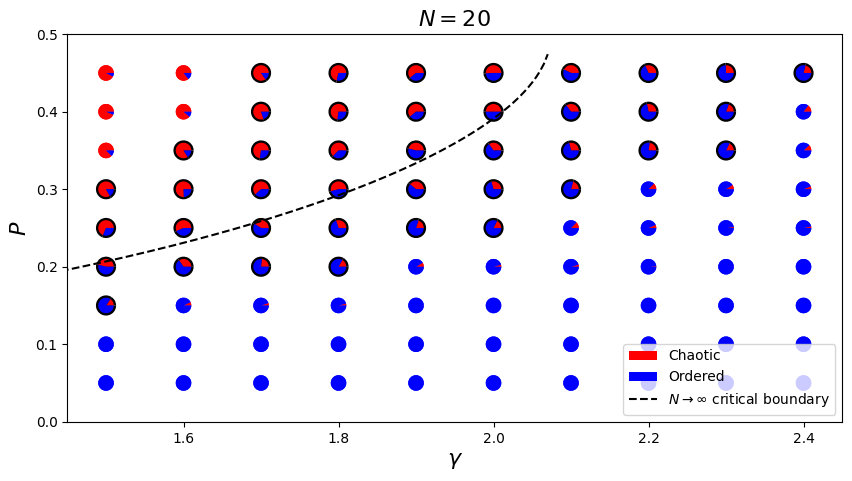

C:\Users\jcroz\AppData\Local\Temp\ipykernel_5880\2409750442.py:8: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(xvals,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xvals],'k--')


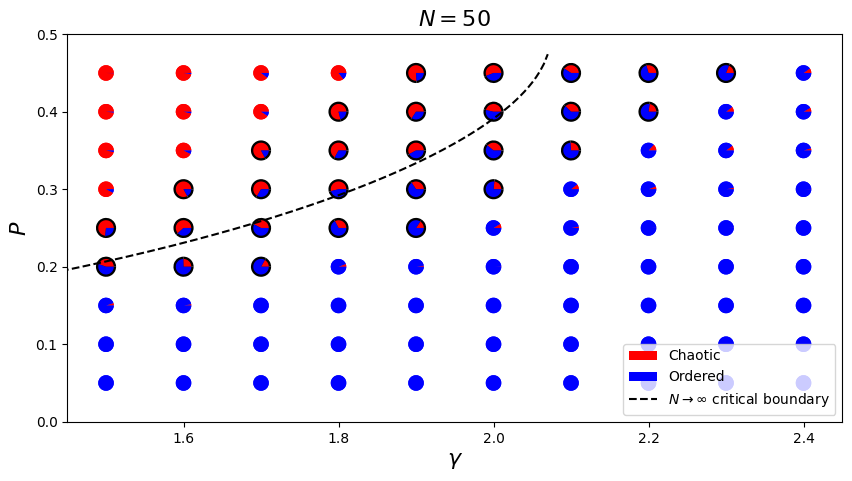

C:\Users\jcroz\AppData\Local\Temp\ipykernel_5880\2409750442.py:8: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(xvals,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xvals],'k--')


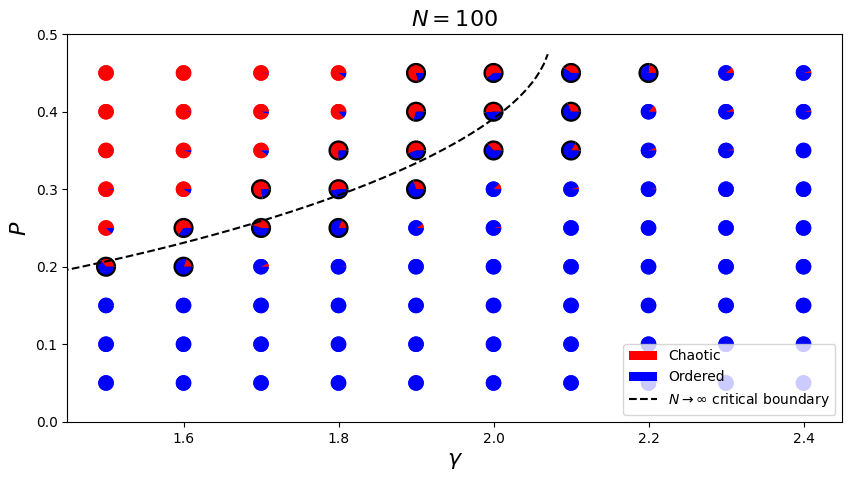

C:\Users\jcroz\AppData\Local\Temp\ipykernel_5880\2409750442.py:8: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(xvals,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xvals],'k--')


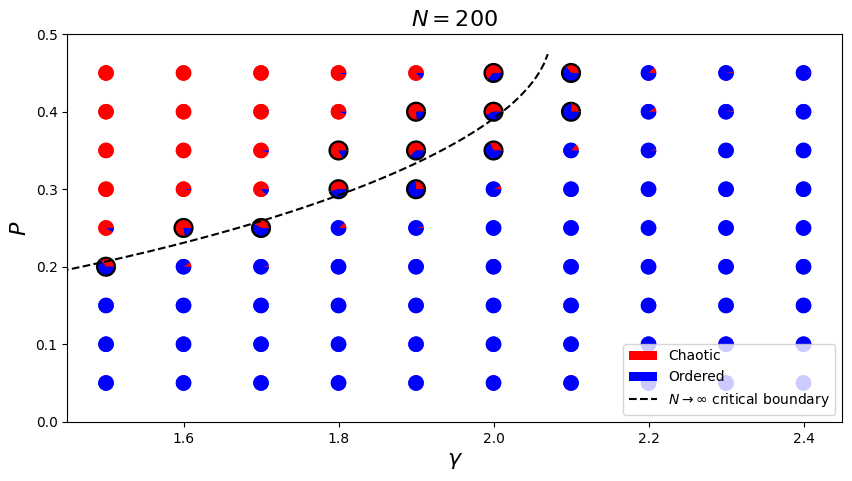

In [5]:
biases = np.arange(0.05,0.5,0.05).round(2)
gammas = np.arange(1.5,2.5,0.1).round(2)
fs=16
for N in Nvals:
    fig, ax = plt.subplots(figsize=(10, 10),facecolor='white')
    
    xvals = np.arange(1.4, 2.6, 0.005)
    ax.plot(xvals,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xvals],'k--') 
    
    for g,p in itertools.product(gammas,biases):
        g=g.round(2)
        p=p.round(2)
        ones = (dfall[(dfall['N'] == N) & (dfall['gamma'] == g) & (dfall['bias'] == p)]['Derrida']>1).mean()
        ax.pie([ones, 1-ones], center=(g, p), radius=0.01, colors=['r', 'b'], frame=True)
        if ones > 0.85 or ones < 0.15:
            ax.pie([ones, 1-ones], center=(g, p), radius=0.01, colors=['r', 'b'], frame=True)
        else:
            ax.pie([ones, 1-ones], center=(g, p), radius=0.013, colors=['k', 'k'], frame=True)
            ax.pie([ones, 1-ones], center=(g, p), radius=0.01, colors=['r', 'b'], frame=True)
        ax.set_xlim(1.45,2.45)
        ax.set_ylim(0,0.5)
        

    legend_elements = [Patch(facecolor='r', label='Chaotic'), Patch(facecolor='b', label='Ordered'), Line2D([0],[0],color='k',linestyle='--',label=r'$N\rightarrow\infty$ critical boundary')]
    plt.title(f'$N=${N}',fontsize=fs)
    plt.xlabel('$\gamma$',fontsize=fs)
    plt.ylabel('$P$',fontsize=fs)
    ax.legend(handles=legend_elements, loc='lower right')
    plt.savefig(f'figures/PieChartFigure_{N}.pdf',bbox_inches='tight')
    plt.savefig(f'figures/PieChartFigure_{N}.png',bbox_inches='tight')
    plt.show()
    

As expected, the fuzzy boundary becomes sharper as the size of the networks increases, and the boundary appears to be converging to the theoretical prediciton.

#### We consider various ways to fit the critical boundary.
We begin by defining the functional forms we will attempt to fit to and associated helper functions.

In [6]:
from scipy.optimize import curve_fit
def powerlaw(x,c,m,b):
    return c*x**m + b

def linear_law(x, m, b):
    return m*x + b

def critical_kappa(rho,c,m,b):
    return (1/rho)*((1-b)/c)**(1/m)

def critical_kappa_lin(rho,m,b):
    return (1-b)/(m*rho)

def mse(x,y,f):
    return np.nanmean((f(x)-y)**2)

#### We fit power law functions to the critical boundary in RBNs.
As described in the main text, we fit $\sigma^2 k$, $\sigma^2 k_e$, and $H k_e$ to $\delta$ using a power law function for various sizes of network.

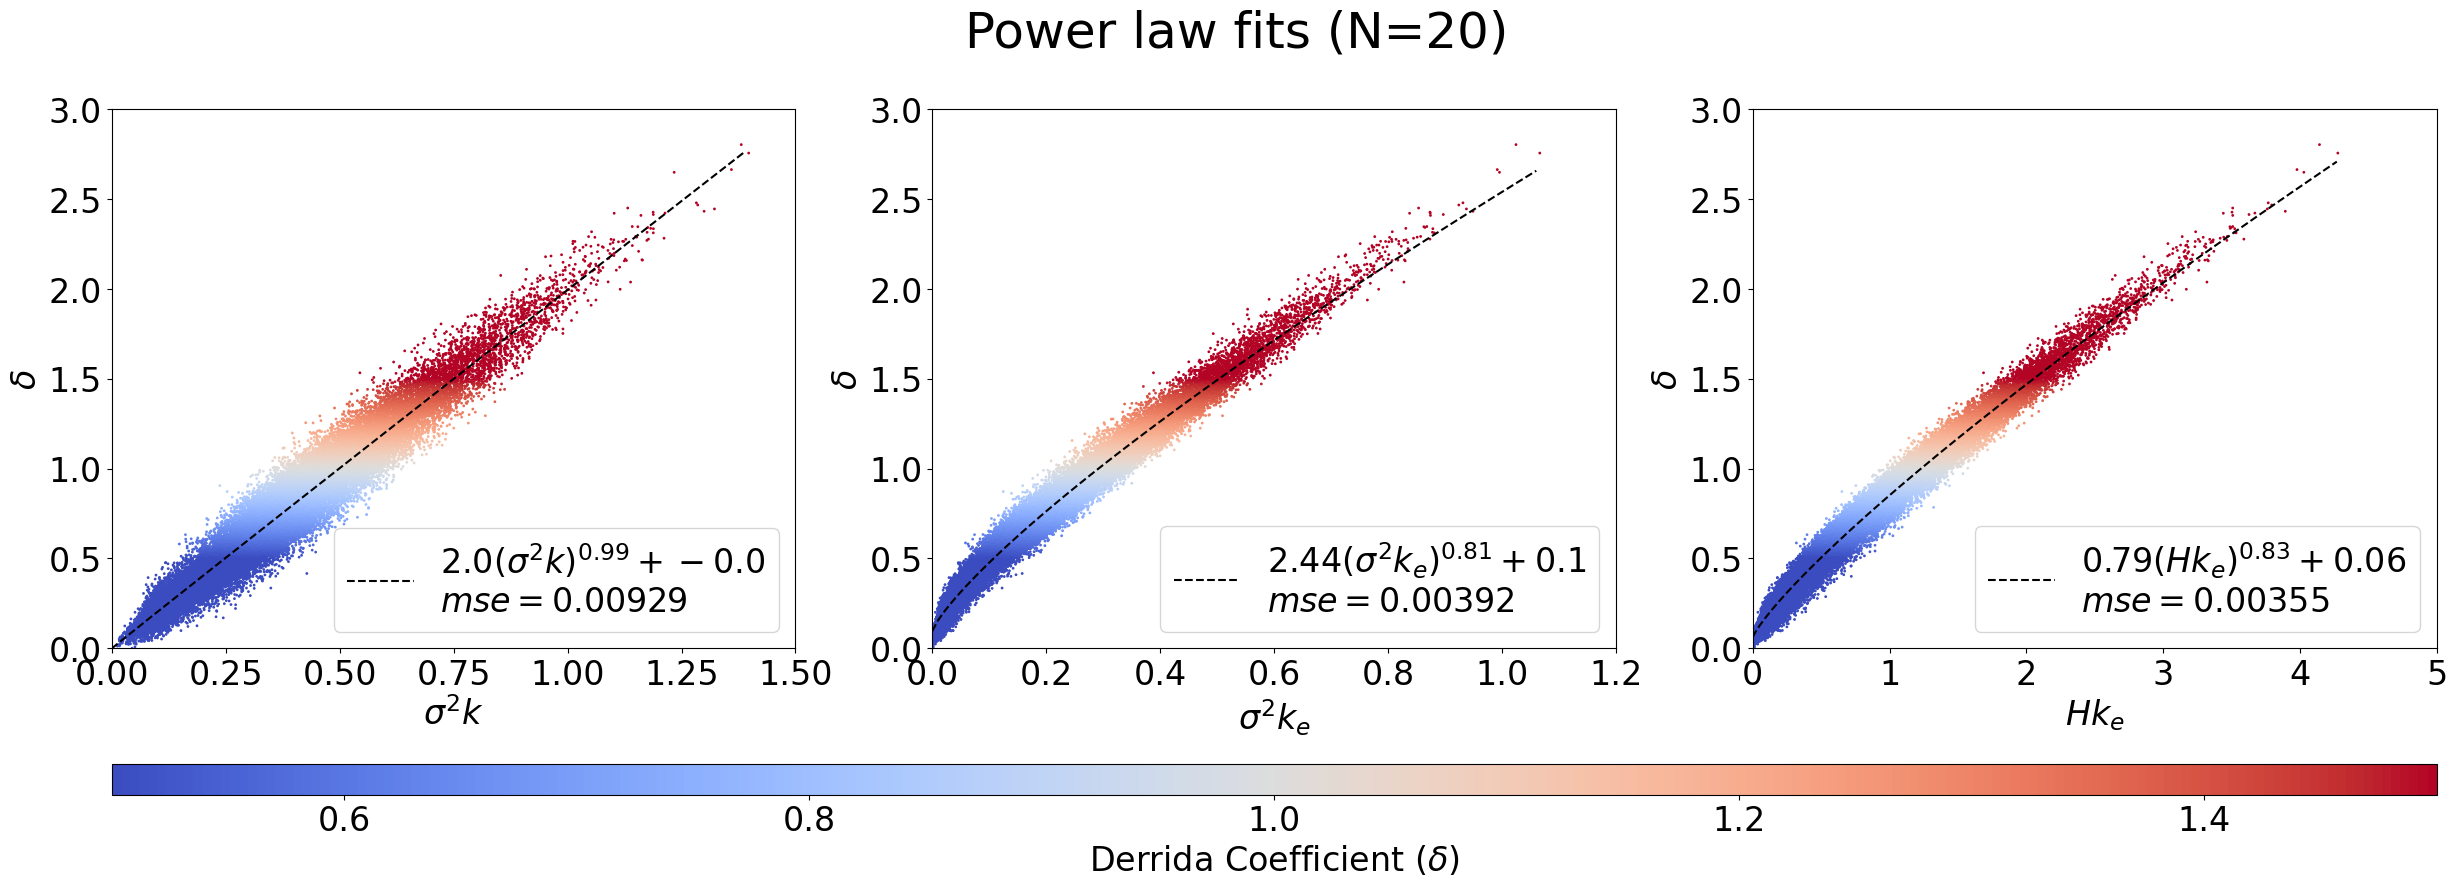

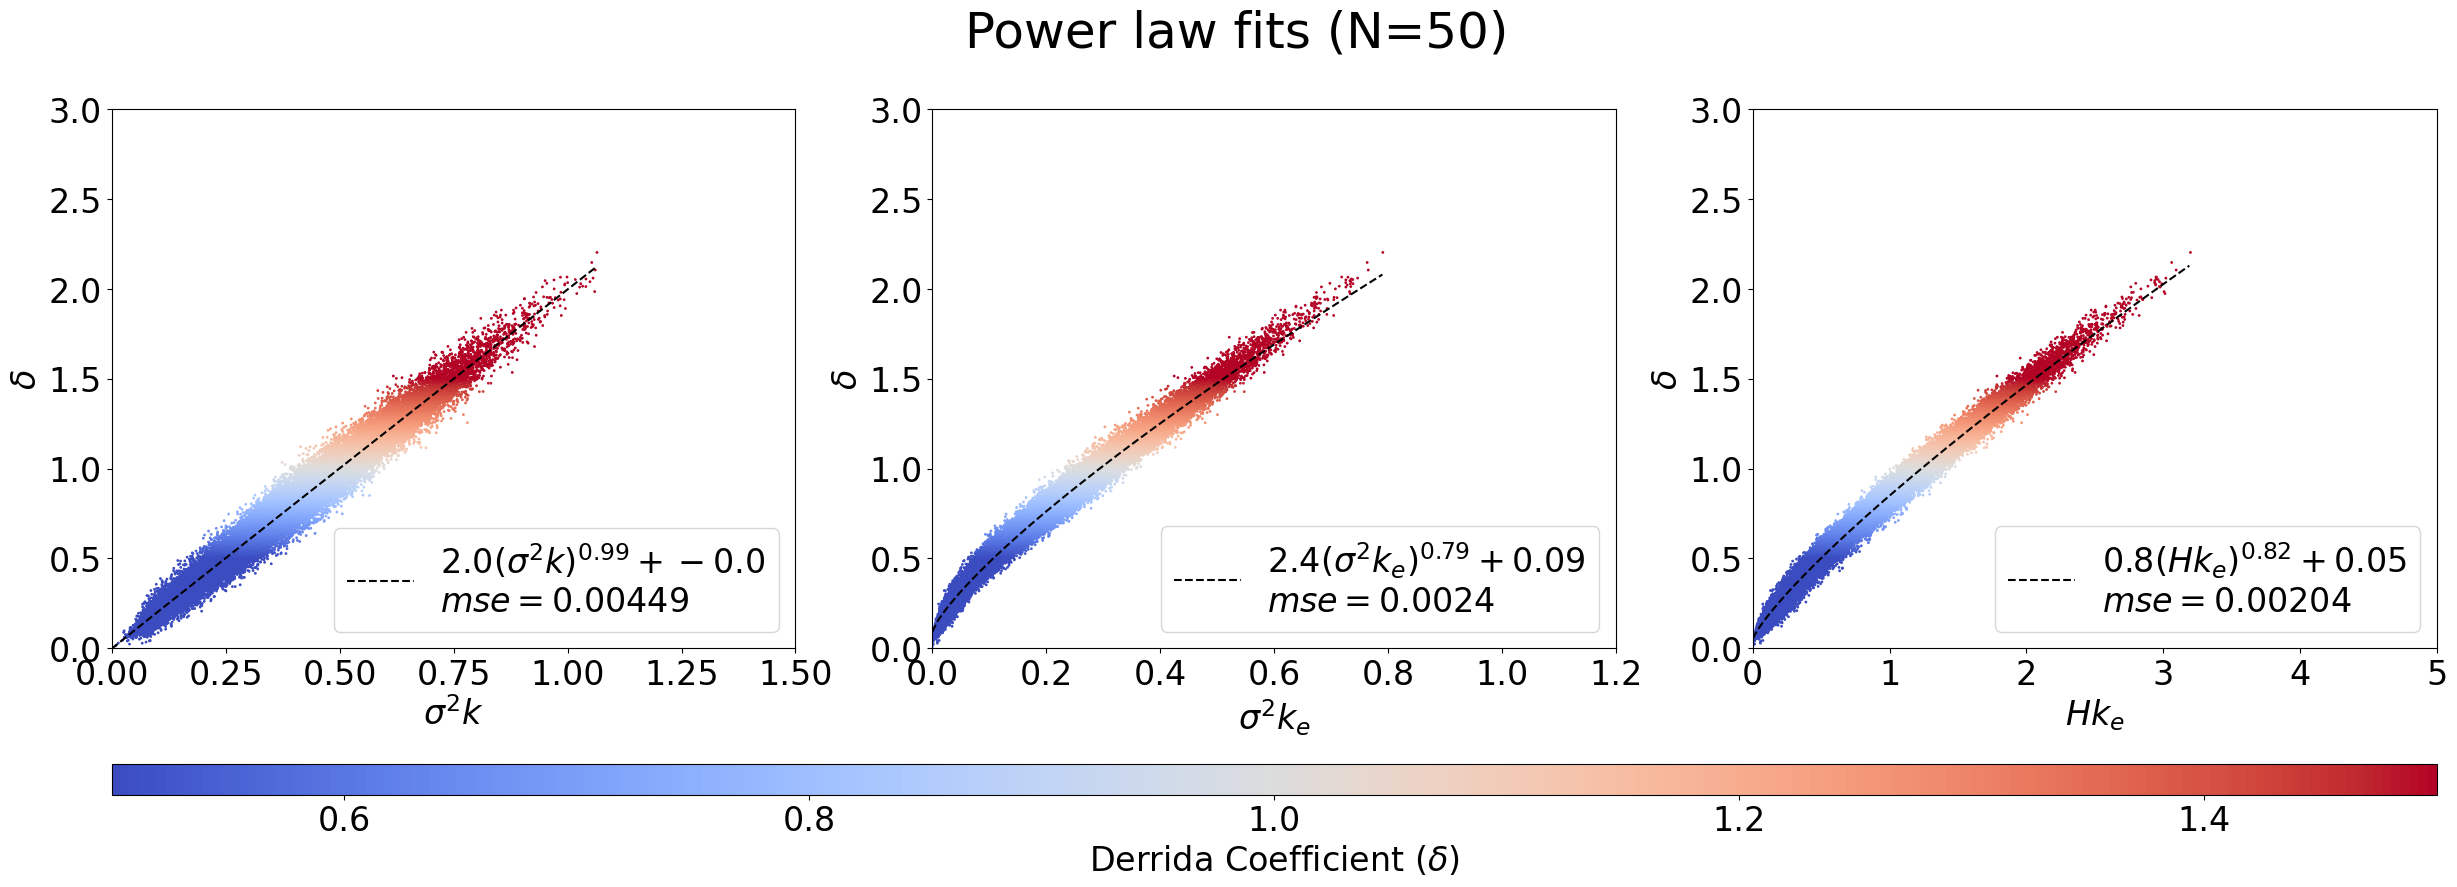

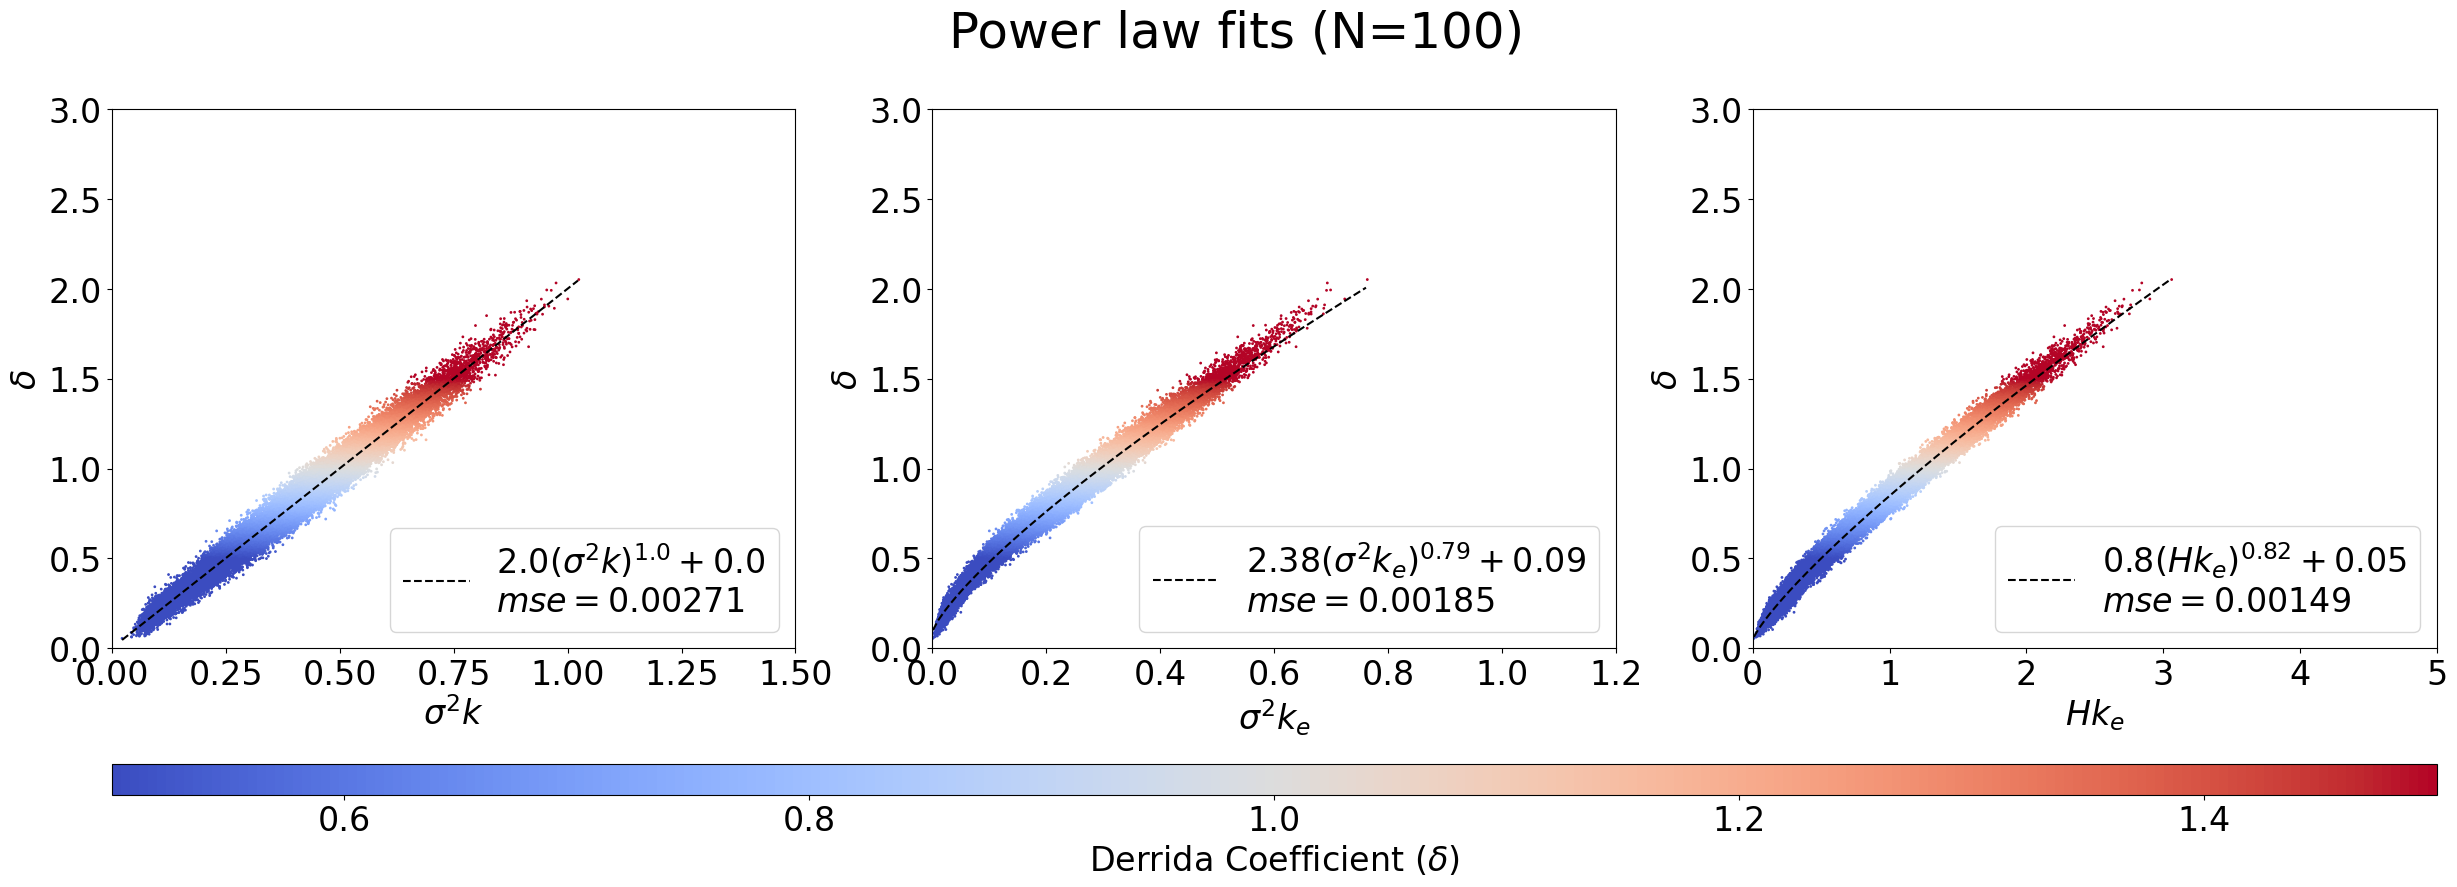

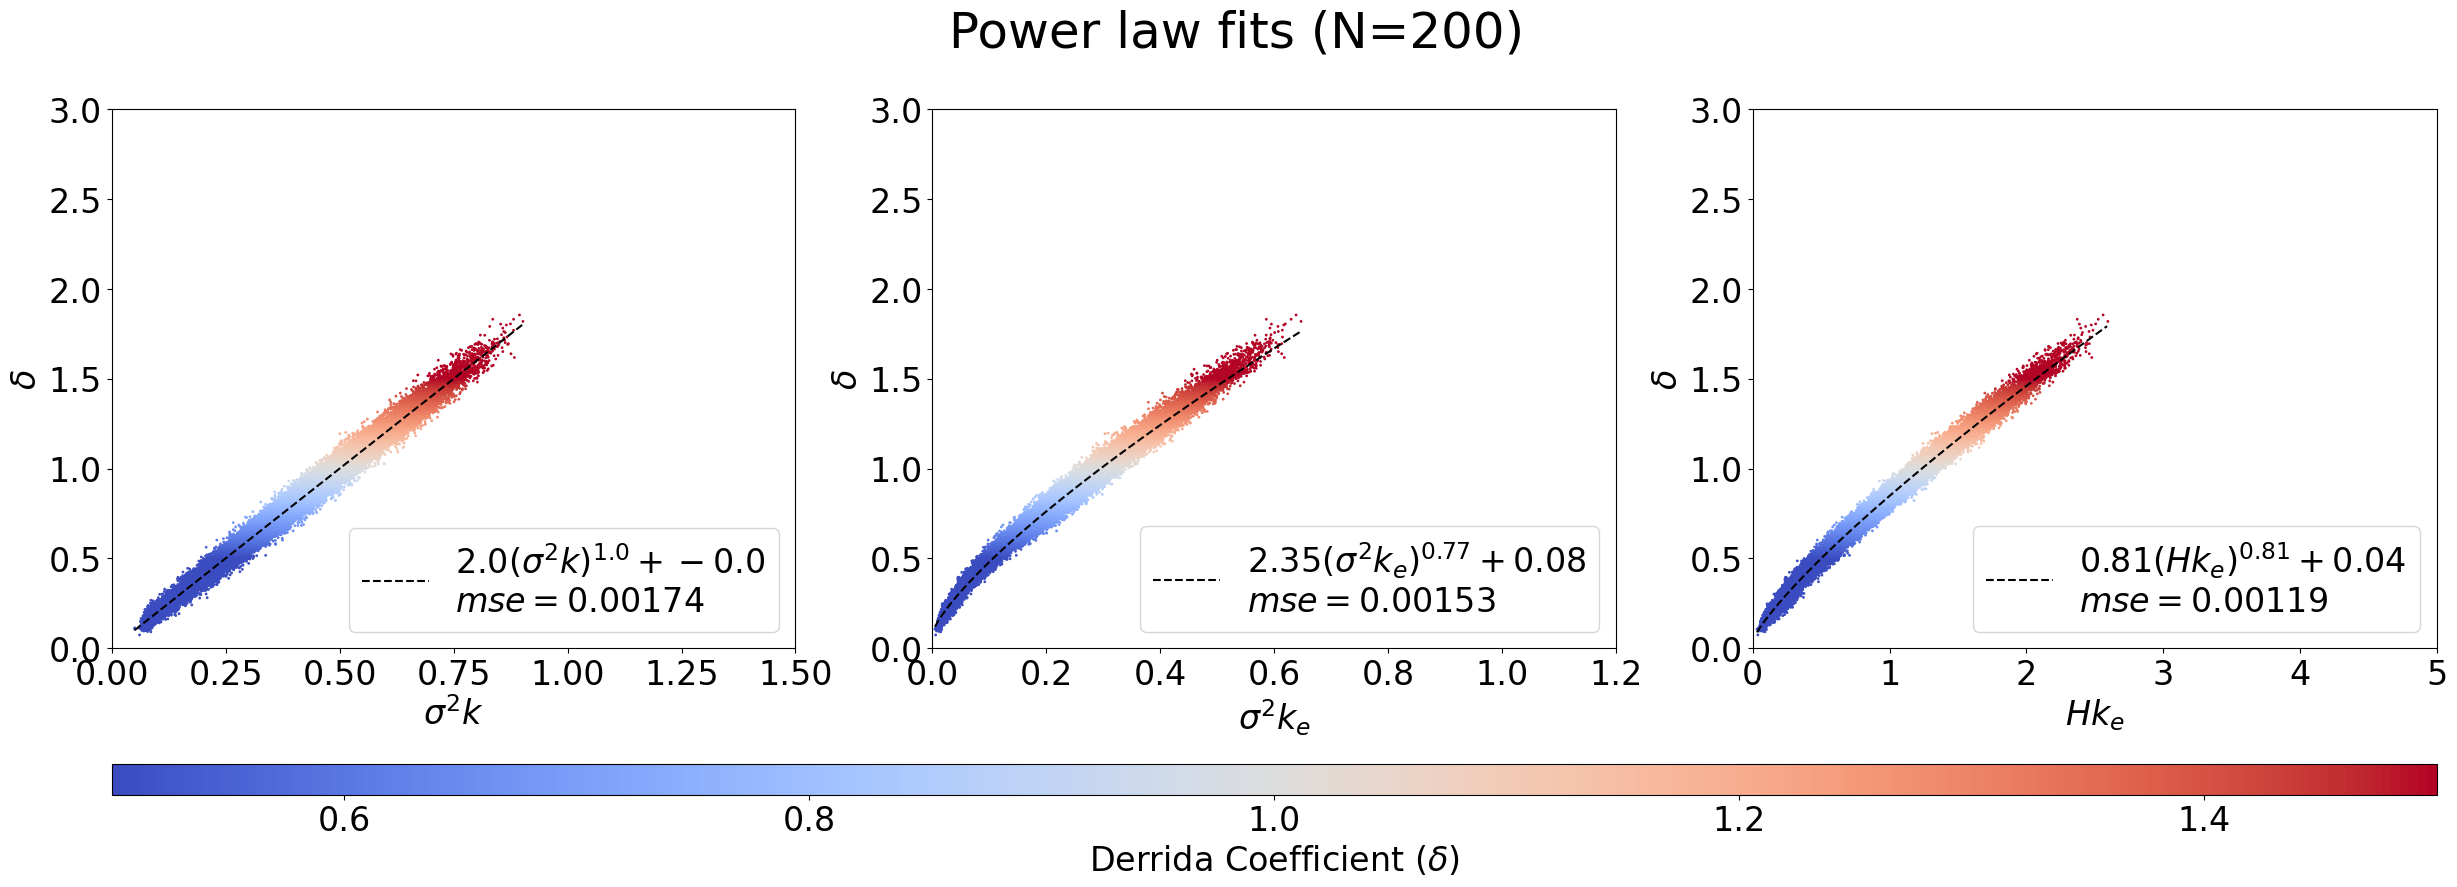

In [7]:
fs = 24
for N in Nvals:
    dfN = dfall[dfall['N']==N]
    
    fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
    cmap = plt.cm.get_cmap('coolwarm')#.reversed()
    x=dfN['avgK']*dfN['avgV']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=powerlaw(xfit,c,m,b)
    gof = mse(x,dfN['Derrida'],lambda xi: powerlaw(xi,c,m,b))
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k)^{mstr}+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[0].plot(xfit,yfit,'k--', label=label)
    sc=ax[0].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[0].set_xlabel("$\sigma^2 k$",fontsize=fs)
    ax[0].set_ylabel("$\delta$",fontsize=fs)
    ax[0].tick_params(axis='both', which='major', labelsize=fs)
    ax[0].legend(fontsize=fs, loc = 'lower right')
    ax[0].set_ylim(0,3)
    ax[0].set_xlim(0,1.5)
    
    x=dfN['avgKe']*dfN['avgV']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=powerlaw(xfit,c,m,b)
    gof = mse(x,dfN['Derrida'],lambda xi: powerlaw(xi,c,m,b))
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k_e)^{mstr}+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[1].plot(xfit,yfit,'k--', label=label)
    sc=ax[1].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))    
    ax[1].set_xlabel("$\sigma^2 k_e$",fontsize=fs)
    ax[1].set_ylabel("$\delta$",fontsize=fs)
    ax[1].tick_params(axis='both', which='major', labelsize=fs)
    ax[1].legend(fontsize=fs, loc = 'lower right')
    ax[1].set_ylim(0,3)
    ax[1].set_xlim(0,1.2)
    
    x=dfN['avgKe']*dfN['avgH']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=powerlaw(xfit,c,m,b)
    gof = mse(x,dfN['Derrida'],lambda xi: powerlaw(xi,c,m,b))
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(Hk_e)^{mstr}+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[2].plot(xfit,yfit,'k--',label=label)
    sc=ax[2].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[2].set_xlabel("$Hk_e$",fontsize=fs)
    ax[2].set_ylabel("$\delta$",fontsize=fs)
    ax[2].tick_params(axis='both', which='major', labelsize=fs)
    ax[2].legend(fontsize=fs, loc = 'lower right')
    ax[2].set_ylim(0,3)
    ax[2].set_xlim(0,5)
    
    cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
    cbar.ax.tick_params(axis='both',labelsize=fs)
    cbar.set_label('Derrida Coefficient ($\delta$)',fontsize=fs)
    plt.suptitle(f'Power law fits ({N=})',fontsize=fs*1.5)
    plt.savefig(f'figures/PowerLawFits_RBN_{N}.pdf',bbox_inches='tight')
    plt.savefig(f'figures/PowerLawFits_RBN_{N}.png',bbox_inches='tight')
    plt.show()

Note a small but consistent improvement in the mean squared error when moving from left to right in the above figures.

#### We repeat the procedure using a partial linear fit.
The values of $\delta$ for the partial fit are chosen so that the data are approximately linear in all cases and for agreement with values calculated for empirical models, which will be analyzed later.

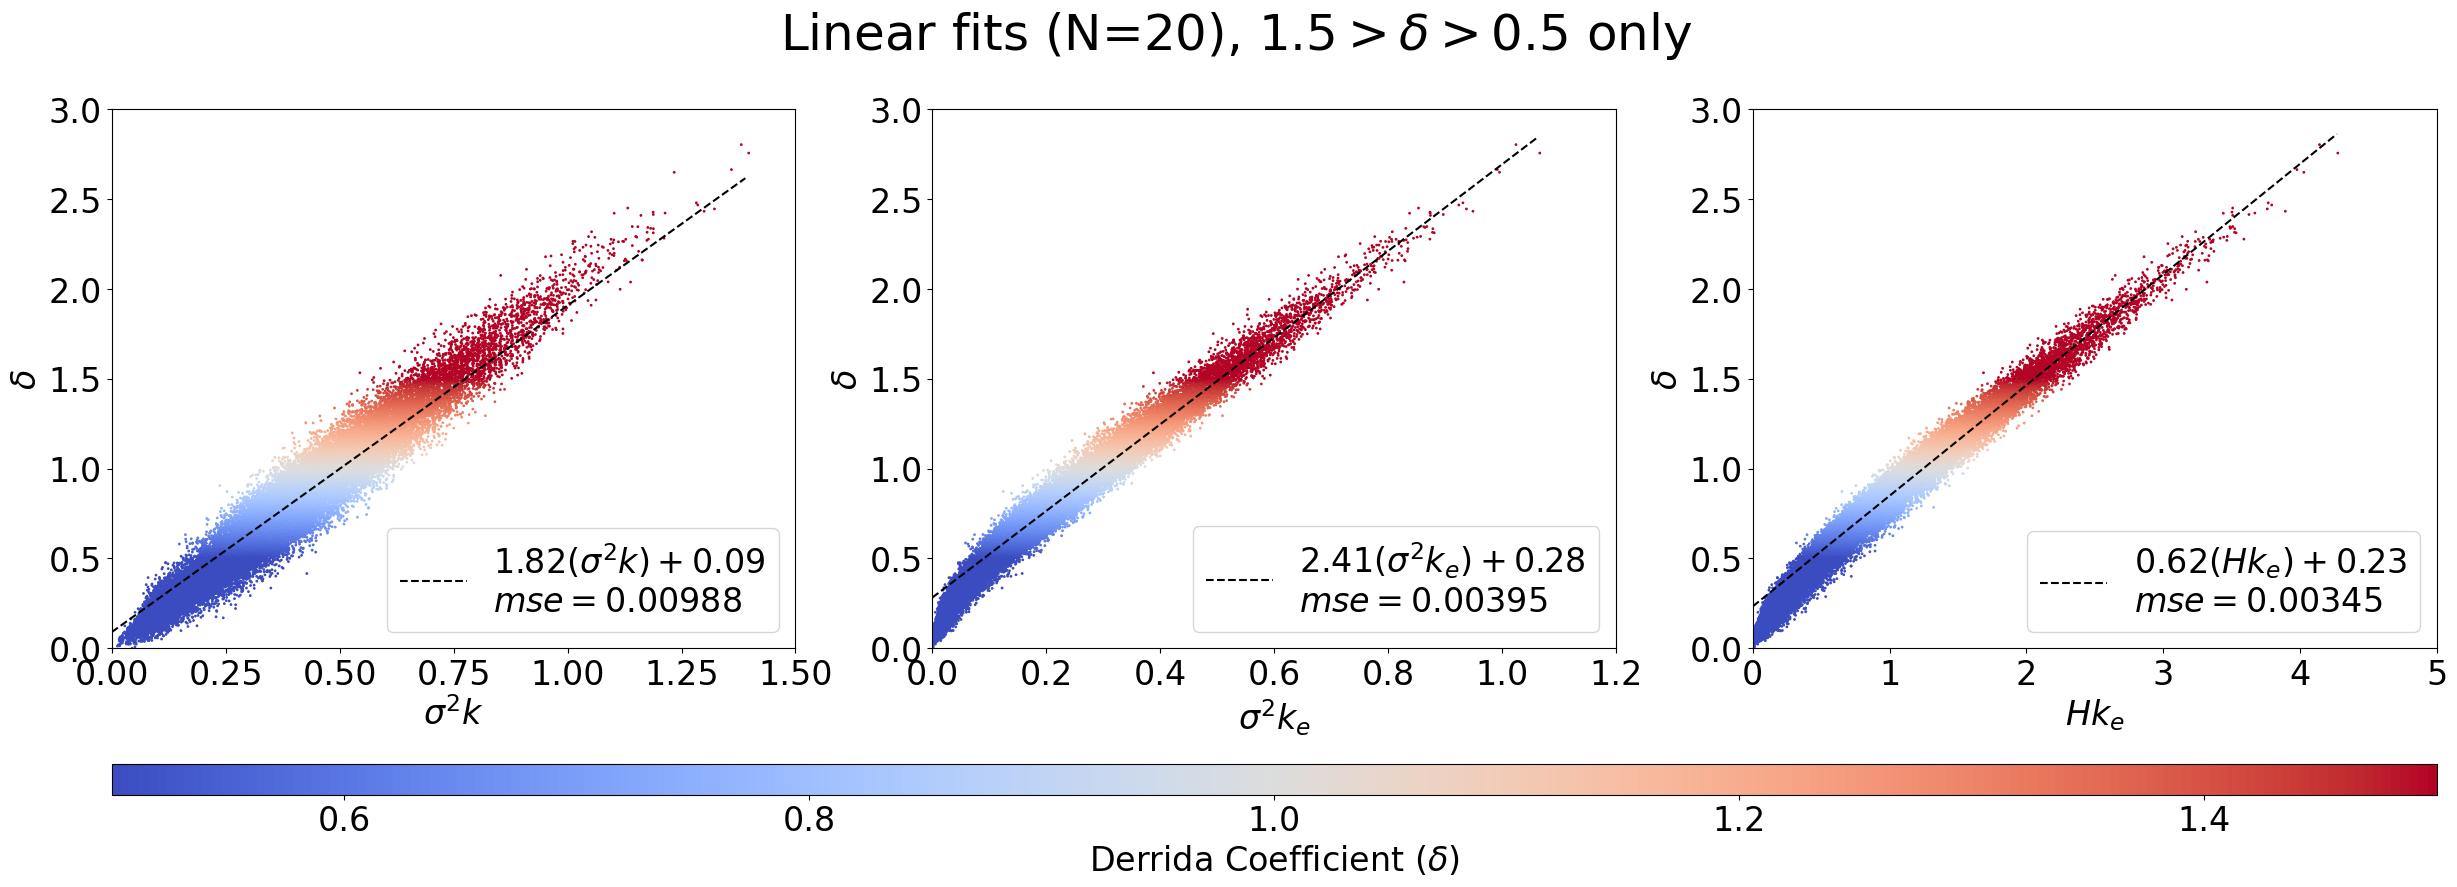

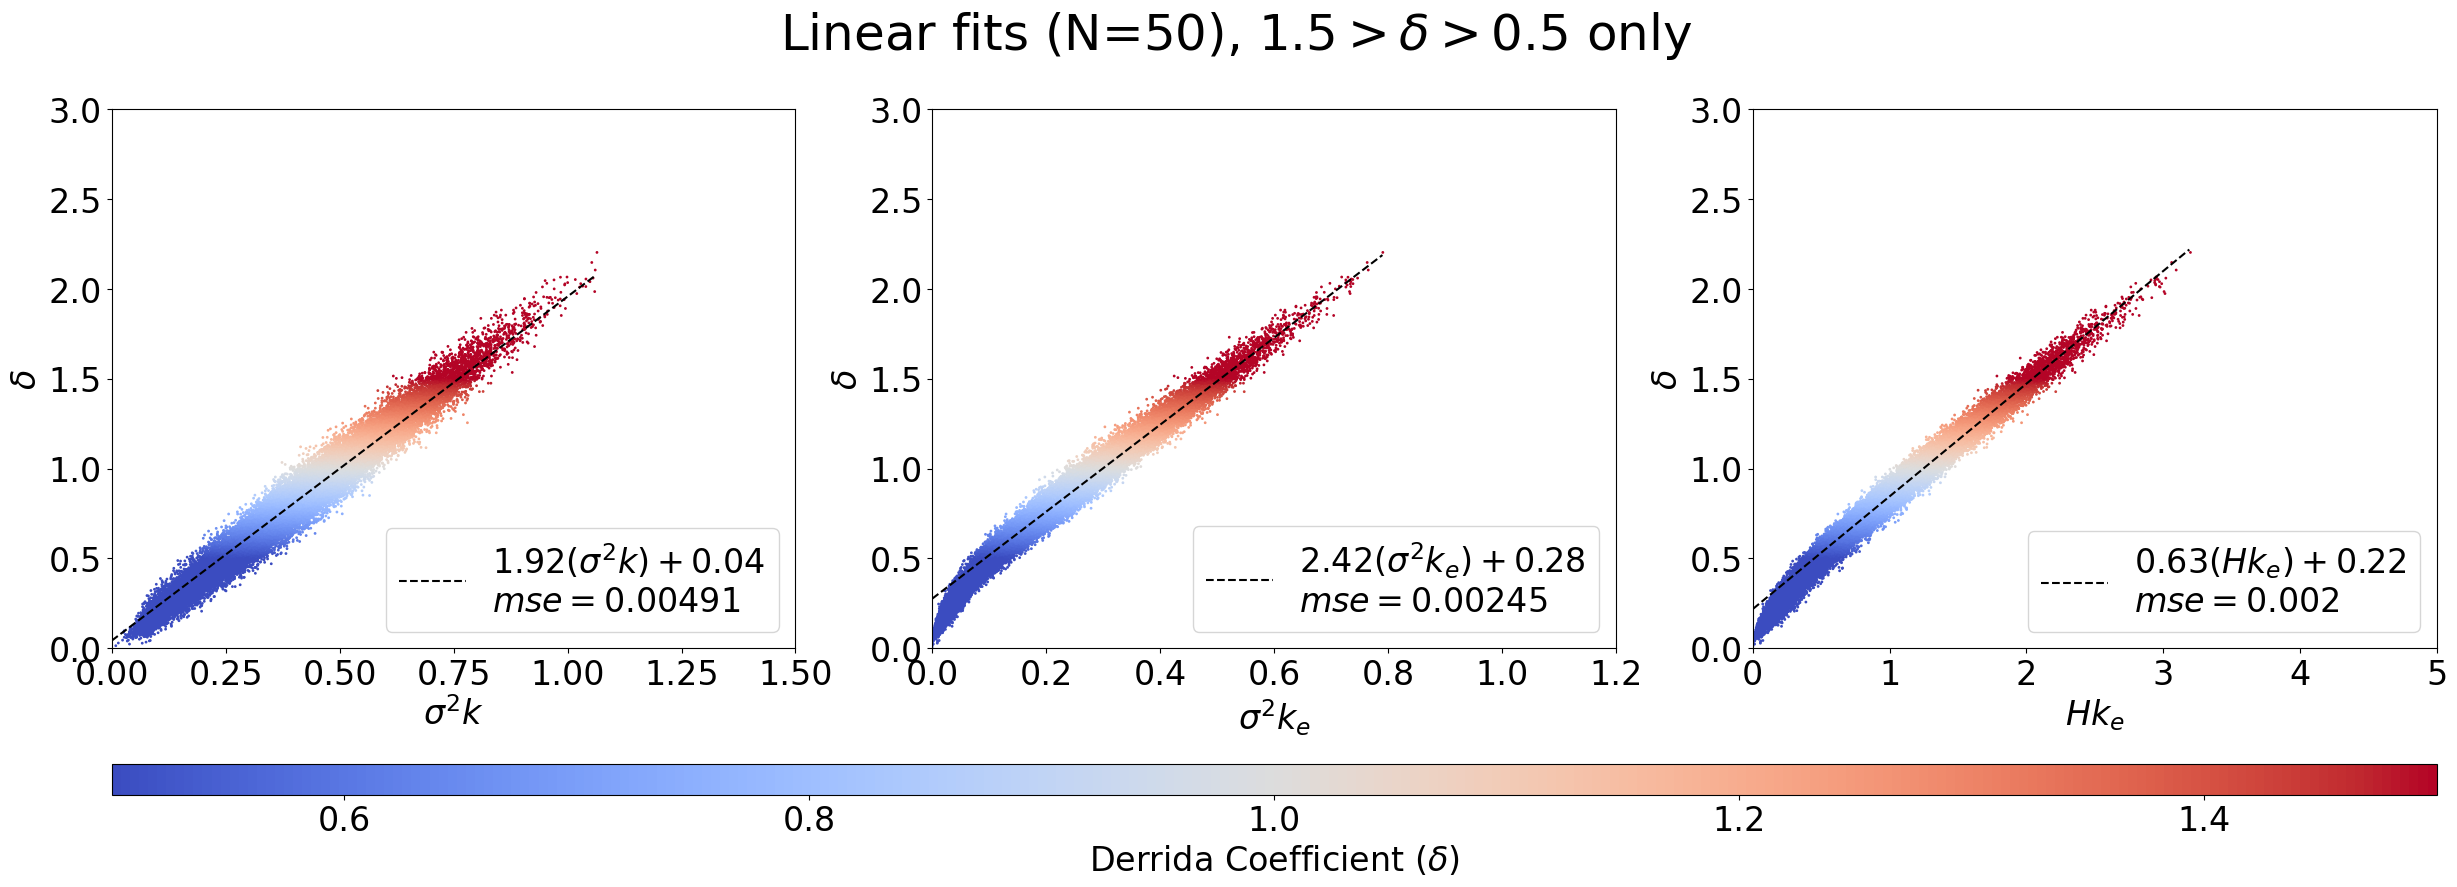

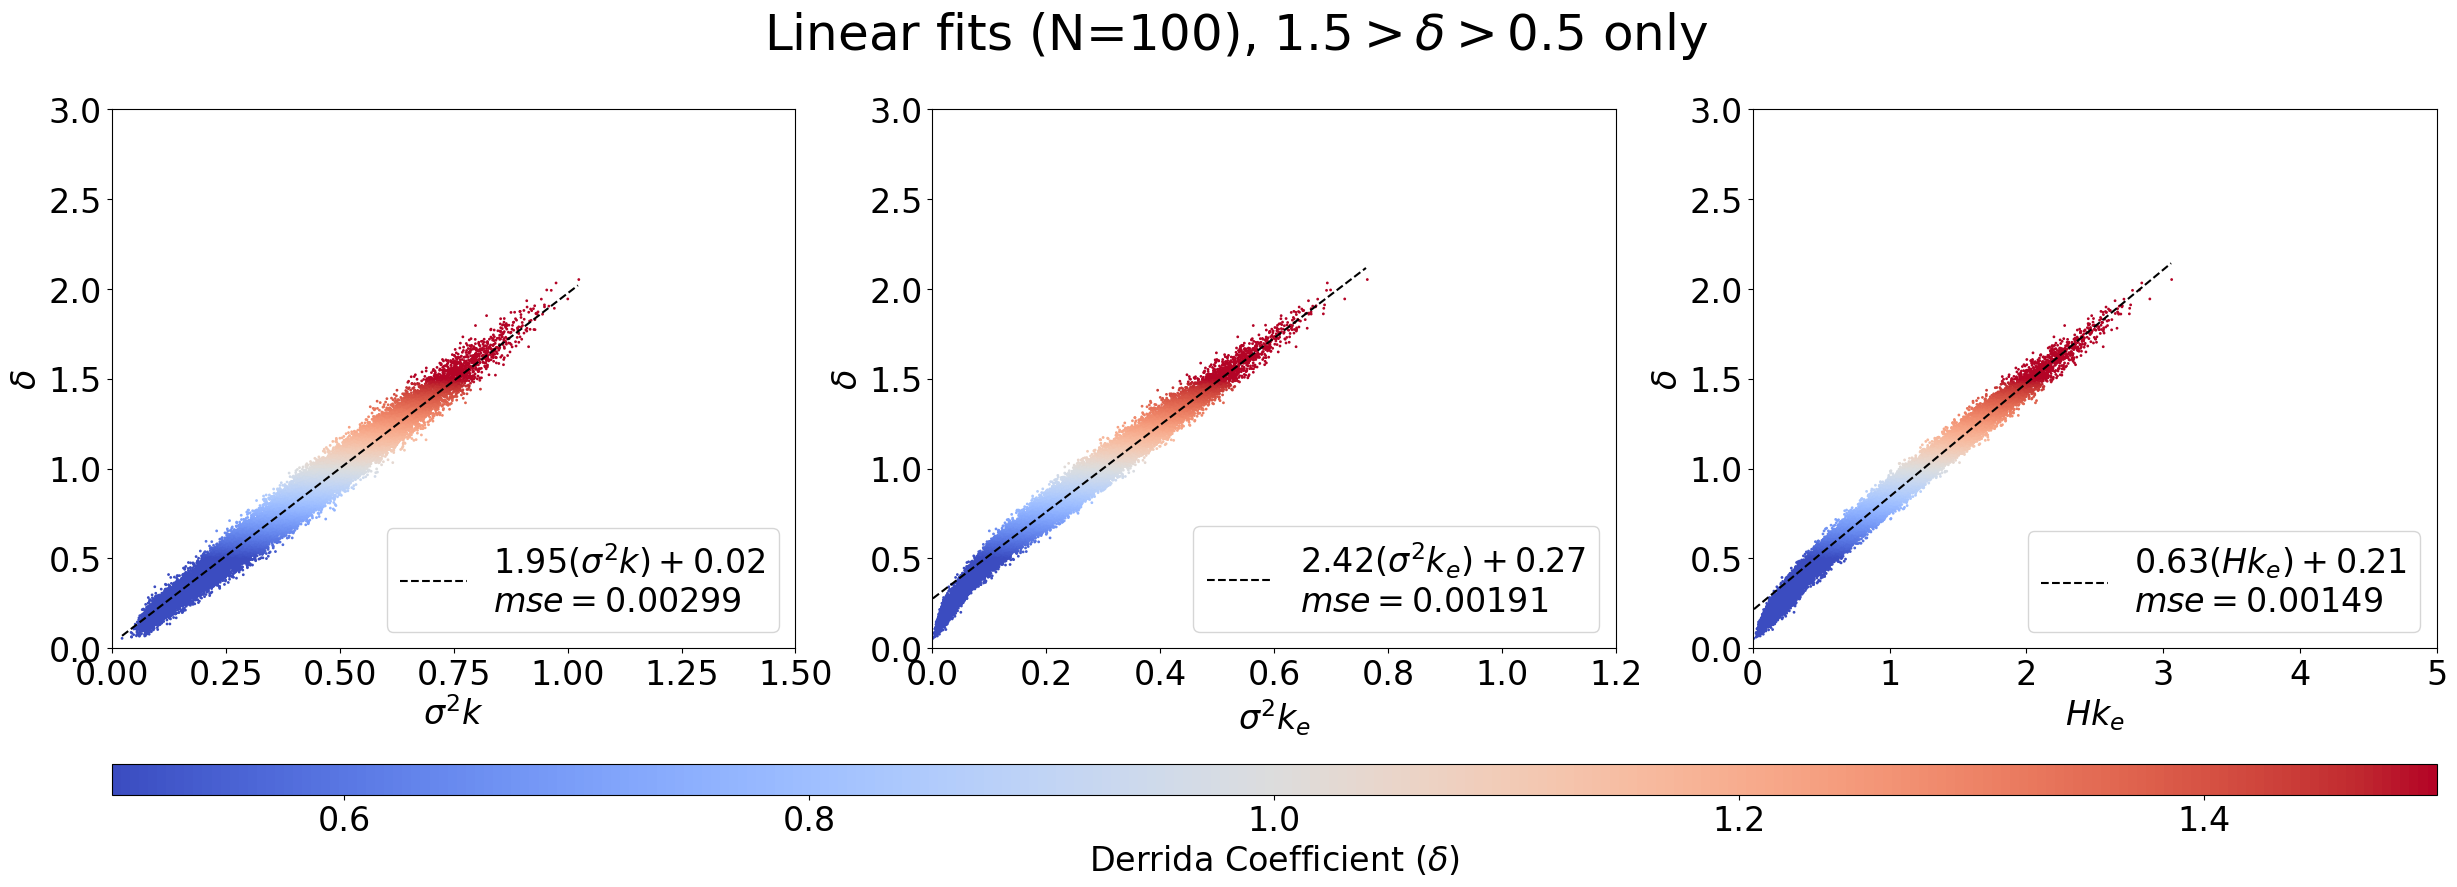

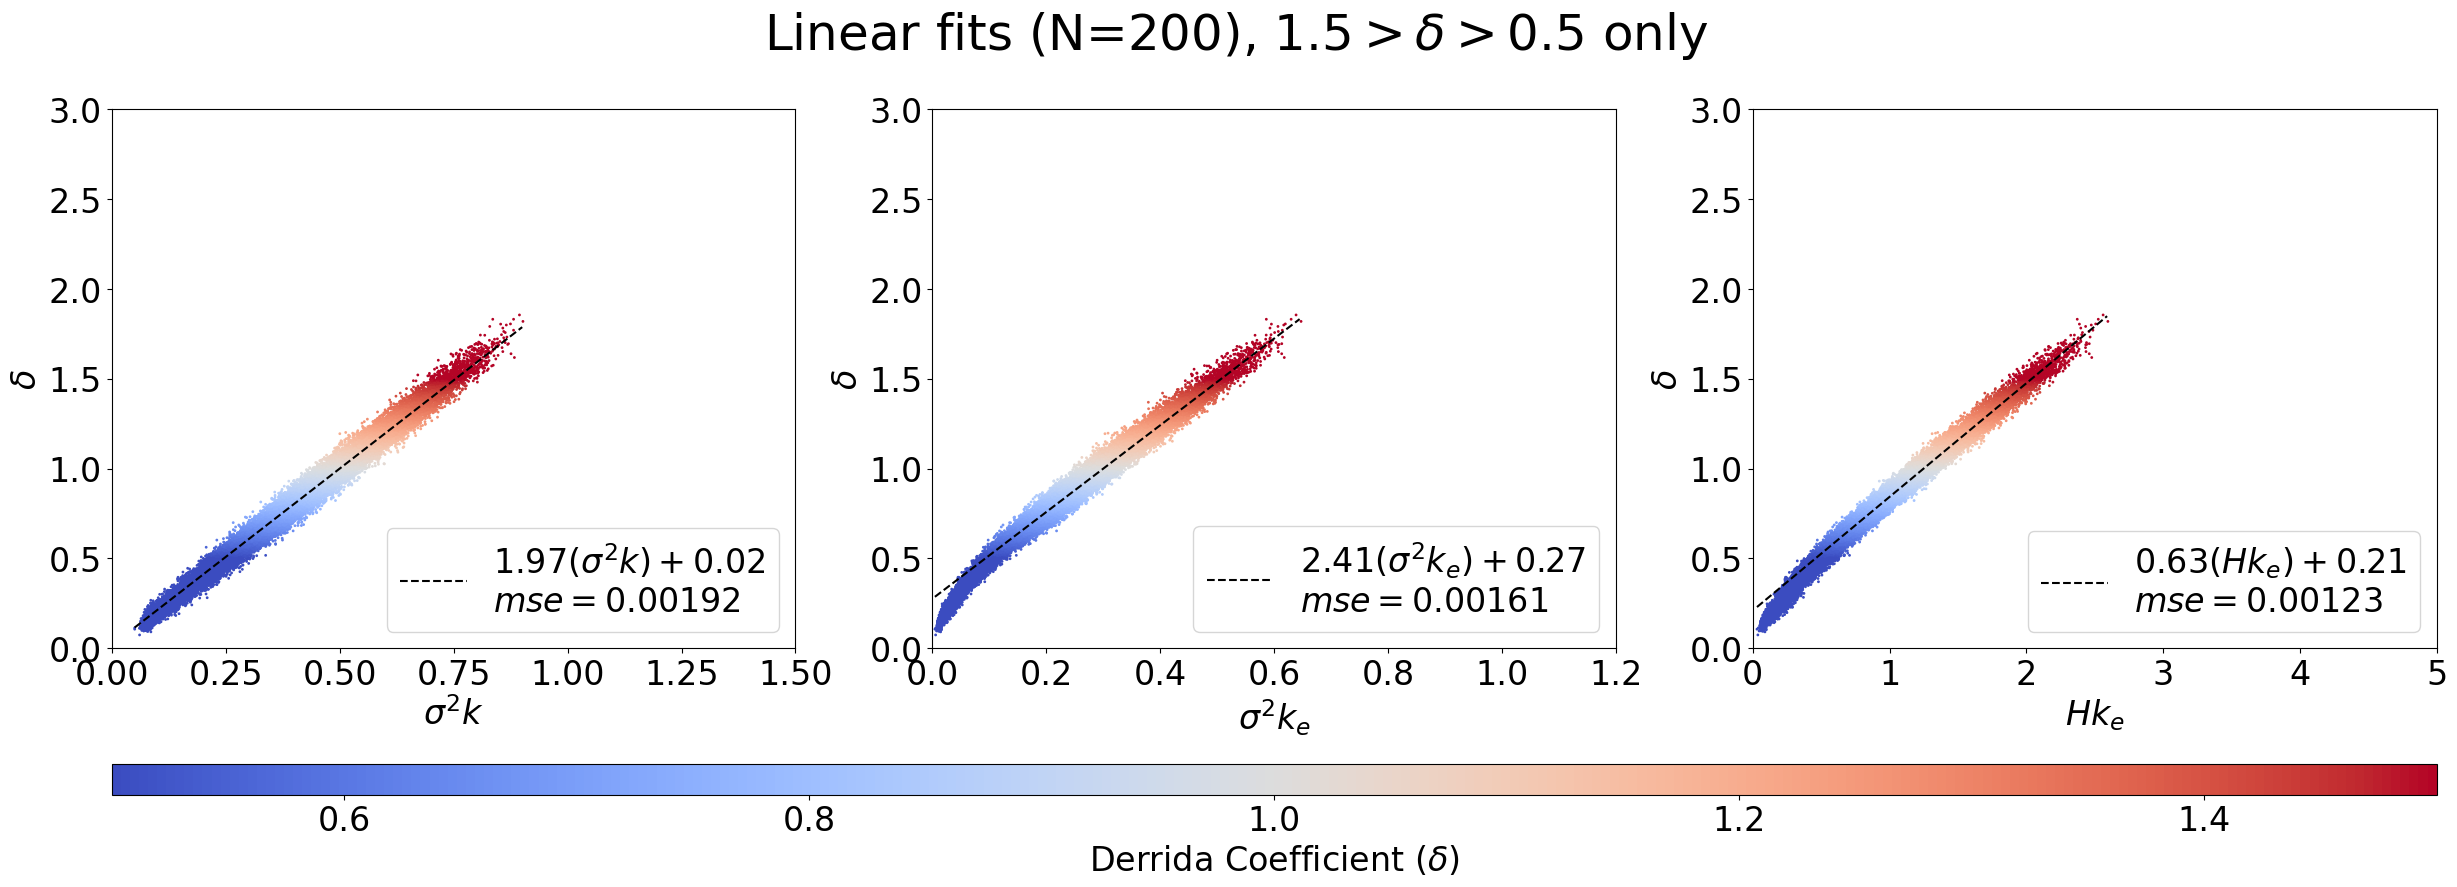

In [8]:
fs = 24
for N in Nvals:
    dfN = dfall[dfall['N']==N]
    dselect = (1.5>dfN['Derrida']) & (dfN['Derrida']>0.5)
    
    fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
    cmap = plt.cm.get_cmap('coolwarm')#.reversed()
    x=dfN['avgK']*dfN['avgV'] / (dselect)
    y=dfN['Derrida']
    popt, pcov = curve_fit(linear_law,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    x=dfN['avgK']*dfN['avgV']
    m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=linear_law(xfit,m,b)
    gof = mse(x[dselect],dfN['Derrida'][dselect],lambda xi: linear_law(xi,m,b))
    label = f'${np.round(m,2)}(\sigma^2 k)+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[0].plot(xfit,yfit,'k--', label=label)
    sc=ax[0].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[0].set_xlabel("$\sigma^2 k$",fontsize=fs)
    ax[0].set_ylabel("$\delta$",fontsize=fs)
    ax[0].tick_params(axis='both', which='major', labelsize=fs)
    ax[0].legend(fontsize=fs, loc = 'lower right')
    ax[0].set_ylim(0,3)
    ax[0].set_xlim(0,1.5)
    
    x=dfN['avgKe']*dfN['avgV'] / (dselect)
    popt, pcov = curve_fit(linear_law,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    x=dfN['avgKe']*dfN['avgV']
    m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=linear_law(xfit,m,b)
    gof = mse(x[dselect],dfN['Derrida'][dselect],lambda xi: linear_law(xi,m,b))
    label = f'${np.round(m,2)}(\sigma^2 k_e)+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[1].plot(xfit,yfit,'k--', label=label)
    sc=ax[1].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))    
    ax[1].set_xlabel("$\sigma^2 k_e$",fontsize=fs)
    ax[1].set_ylabel("$\delta$",fontsize=fs)
    ax[1].tick_params(axis='both', which='major', labelsize=fs)
    ax[1].legend(fontsize=fs, loc = 'lower right')
    ax[1].set_ylim(0,3)
    ax[1].set_xlim(0,1.2)
    
    x=dfN['avgKe']*dfN['avgH']
    x=dfN['avgKe']*dfN['avgH'] / (dselect)
    popt, pcov = curve_fit(linear_law,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    x=dfN['avgKe']*dfN['avgH']
    m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=linear_law(xfit,m,b)
    gof = mse(x[dselect],dfN['Derrida'][dselect],lambda xi: linear_law(xi,m,b))
    label = f'${np.round(m,2)}(Hk_e)+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[2].plot(xfit,yfit,'k--',label=label)
    sc=ax[2].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[2].set_xlabel("$Hk_e$",fontsize=fs)
    ax[2].set_ylabel("$\delta$",fontsize=fs)
    ax[2].tick_params(axis='both', which='major', labelsize=fs)
    ax[2].legend(fontsize=fs, loc = 'lower right')
    ax[2].set_ylim(0,3)
    ax[2].set_xlim(0,5)
    
    cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
    cbar.ax.tick_params(axis='both',labelsize=fs)
    cbar.set_label('Derrida Coefficient ($\delta$)',fontsize=fs)
    plt.suptitle(f'Linear fits ({N=}), $1.5>\delta > 0.5$ only',fontsize=fs*1.5)
    plt.savefig(f'figures/LinearFits_RBN_{N}.pdf',bbox_inches='tight')
    plt.savefig(f'figures/LinearFits_RBN_{N}.png',bbox_inches='tight')
    plt.show()

Again, there is a small but consistent improvement in mean squared error when moving from the left to the right.

#### We show the power law fits in the connectivity/bias-spread planes.

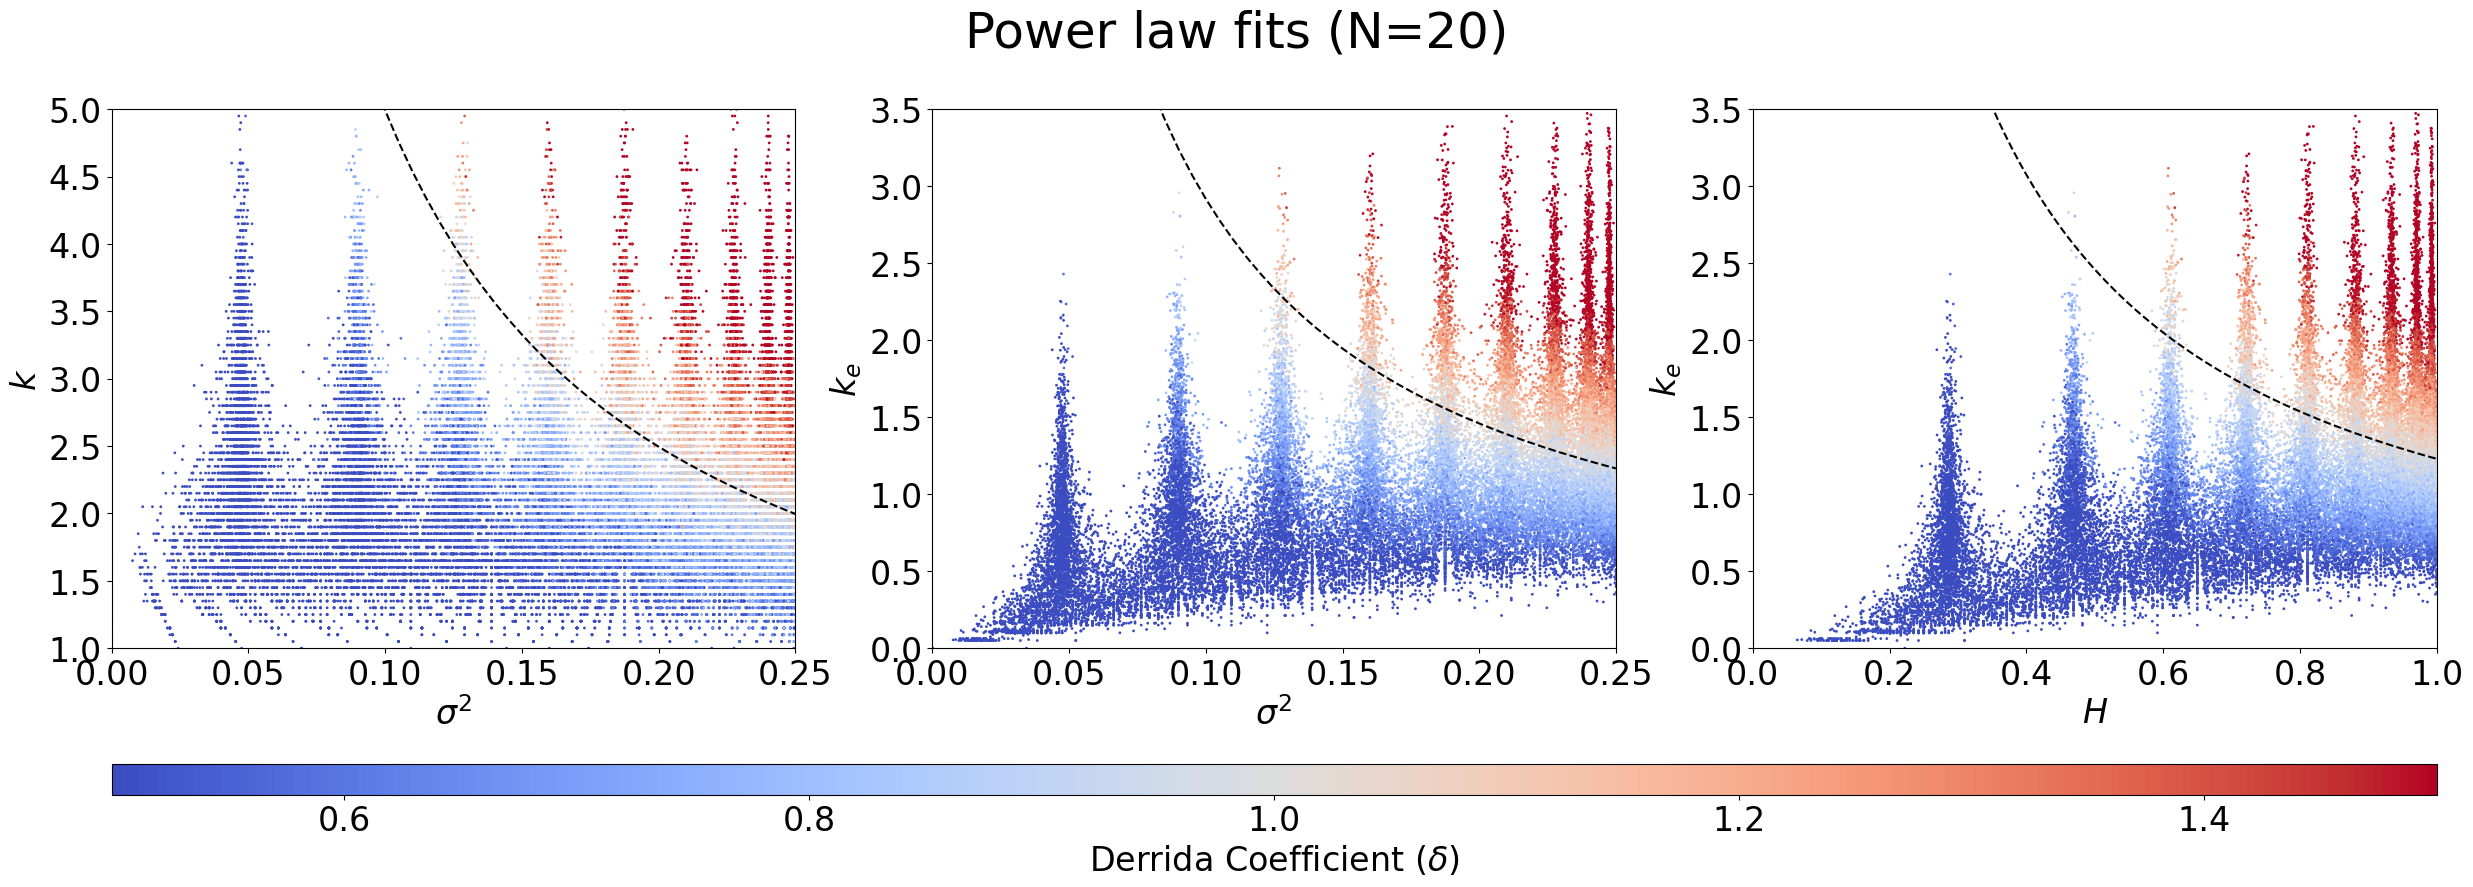

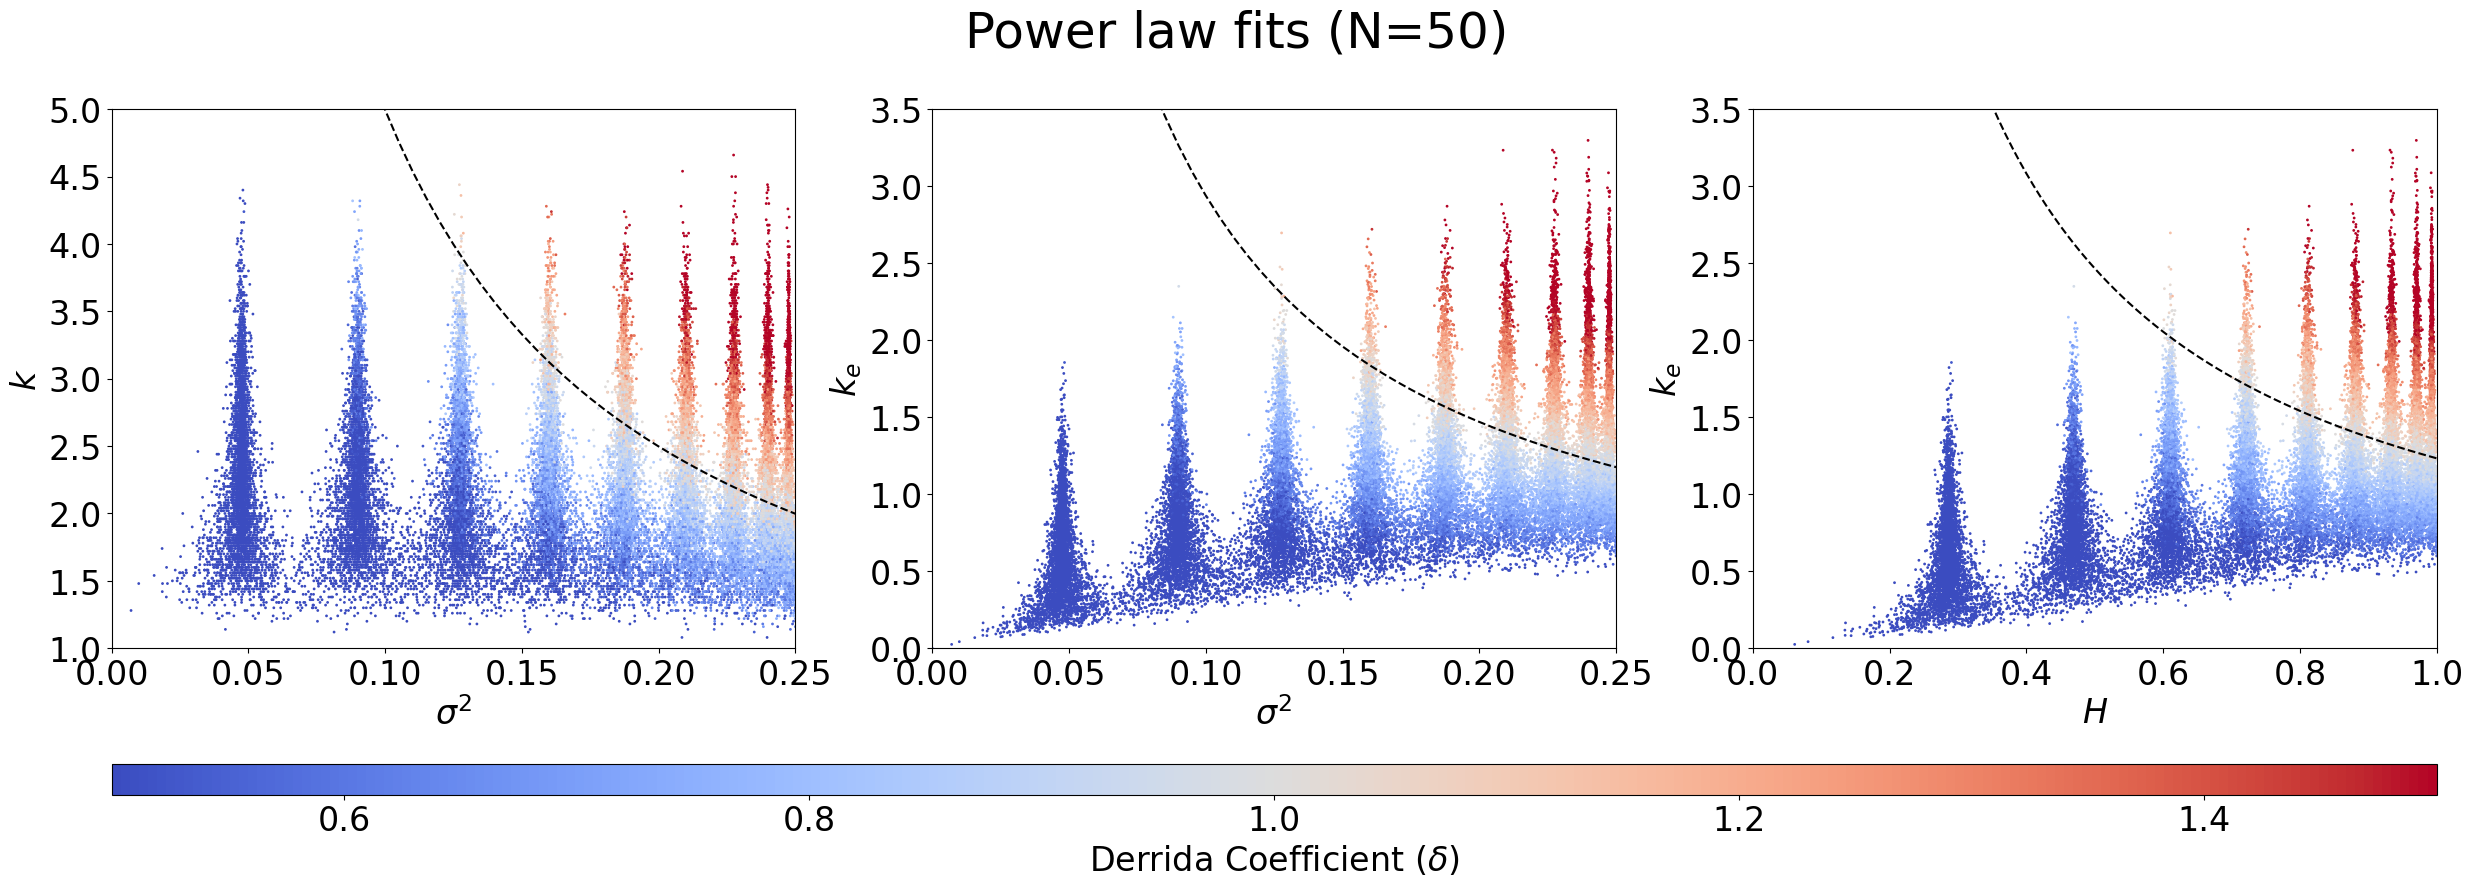

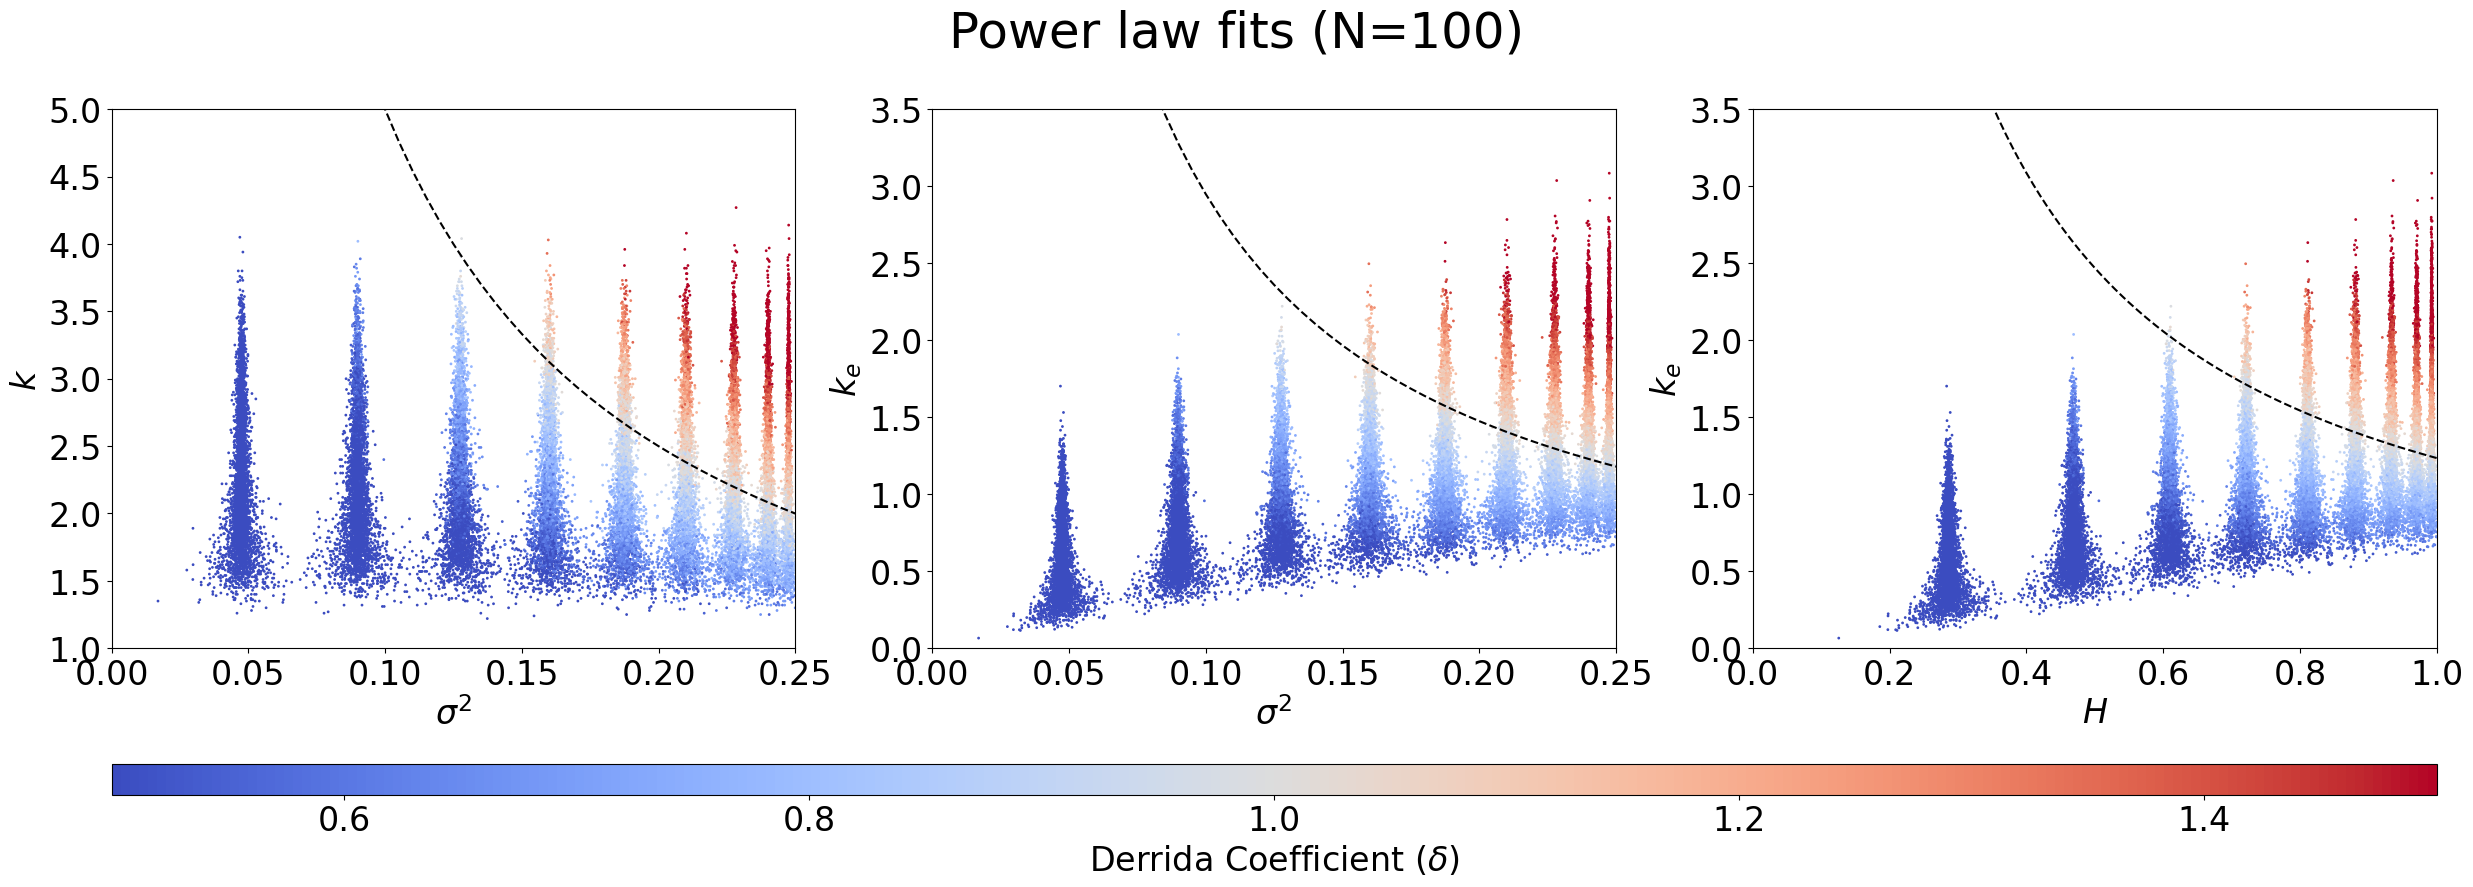

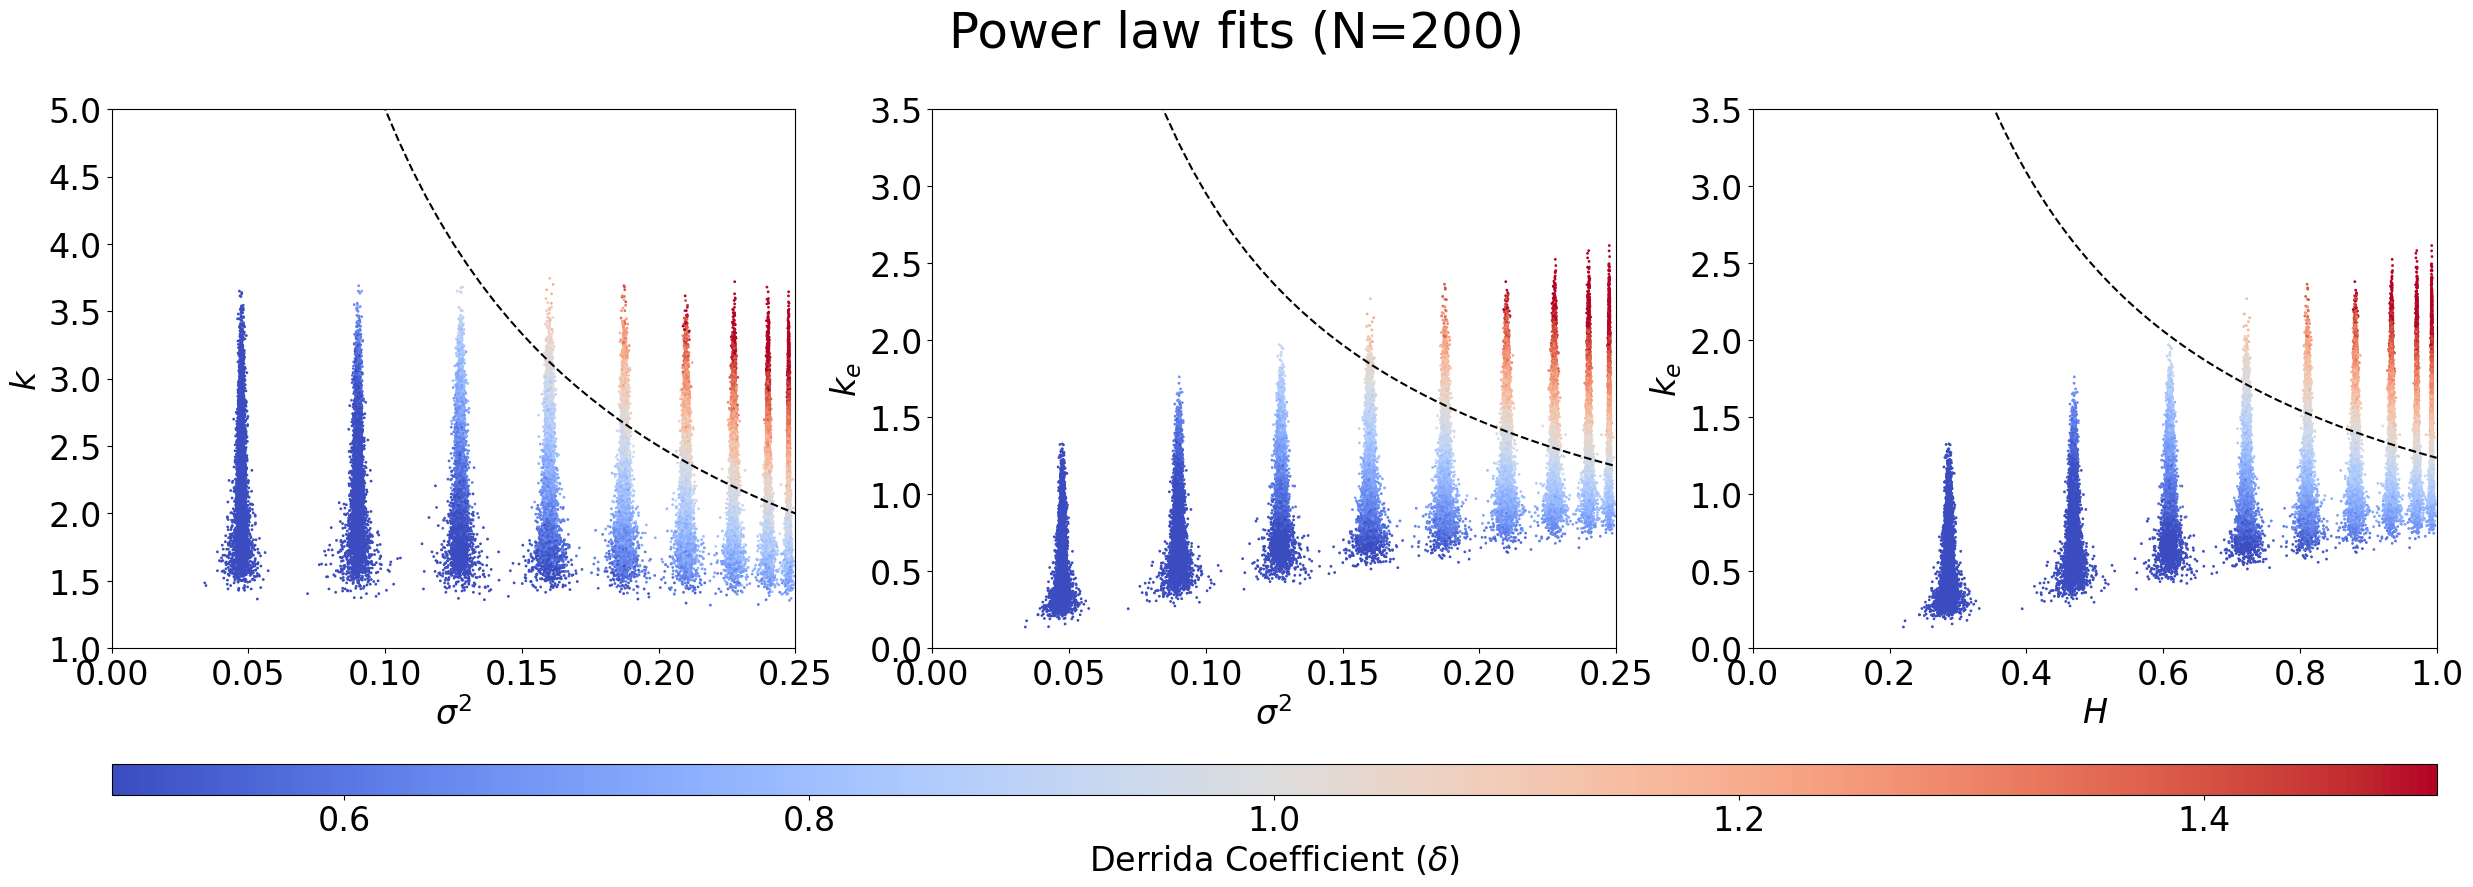

In [9]:
fs = 24
for N in Nvals:
    dfN = dfall[dfall['N']==N]
    
    fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
    cmap = plt.cm.get_cmap('coolwarm')#.reversed()
    x=dfN['avgK']*dfN['avgV']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(0.005,0.255,0.005)
    yfit=critical_kappa(xfit,c,m,b)
    label = 'estimated critical boundary'
    ax[0].plot(xfit,yfit,'k--', label=label)
    sc=ax[0].scatter(dfN['avgV'], dfN['avgK'], s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[0].set_xlabel("$\sigma^2$",fontsize=fs)
    ax[0].set_ylabel("$k$",fontsize=fs)
    ax[0].tick_params(axis='both', which='major', labelsize=fs)
    #ax[0].legend(fontsize=fs, loc = 'lower right')
    ax[0].set_xlim(0,0.25)
    ax[0].set_ylim(1,5)
    
    
    x=dfN['avgKe']*dfN['avgV']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(0.01,0.255,0.005)
    yfit=critical_kappa(xfit,c,m,b)
    label = 'estimated critical boundary'
    ax[1].plot(xfit,yfit,'k--', label=label)
    sc=ax[1].scatter(dfN['avgV'], dfN['avgKe'], s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))    
    ax[1].set_xlabel("$\sigma^2$",fontsize=fs)
    ax[1].set_ylabel("$k_e$",fontsize=fs)
    ax[1].tick_params(axis='both', which='major', labelsize=fs)
    #ax[1].legend(fontsize=fs, loc = 'lower right')
    ax[1].set_ylim(0,3.5)
    ax[1].set_xlim(0,0.25)
    
    x=dfN['avgKe']*dfN['avgH']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    xfit=np.arange(0.01,1.01,0.01)
    yfit=critical_kappa(xfit,c,m,b)
    label = 'estimated critical boundary'
    ax[2].plot(xfit,yfit,'k--',label=label)
    sc=ax[2].scatter(dfN['avgH'], dfN['avgKe'], s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[2].set_xlabel("$H$",fontsize=fs)
    ax[2].set_ylabel("$k_e$",fontsize=fs)
    ax[2].tick_params(axis='both', which='major', labelsize=fs)
    #ax[2].legend(fontsize=fs, loc = 'lower right')
    ax[2].set_ylim(0,3.5)
    ax[2].set_xlim(0,1)
    
    cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
    cbar.ax.tick_params(axis='both',labelsize=fs)
    cbar.set_label('Derrida Coefficient ($\delta$)',fontsize=fs)
    plt.suptitle(f'Power law fits ({N=})',fontsize=fs*1.5)
    plt.savefig(f'figures/PowerLawFitsAlt_RBN_{N}.pdf',bbox_inches='tight')
    plt.savefig(f'figures/PowerLawFitsAlt_RBN_{N}.png',bbox_inches='tight')
    plt.show()

#### Next, we examine confusion matrices describing the ability of these critical boundaries to discriminate between dynamical regimes

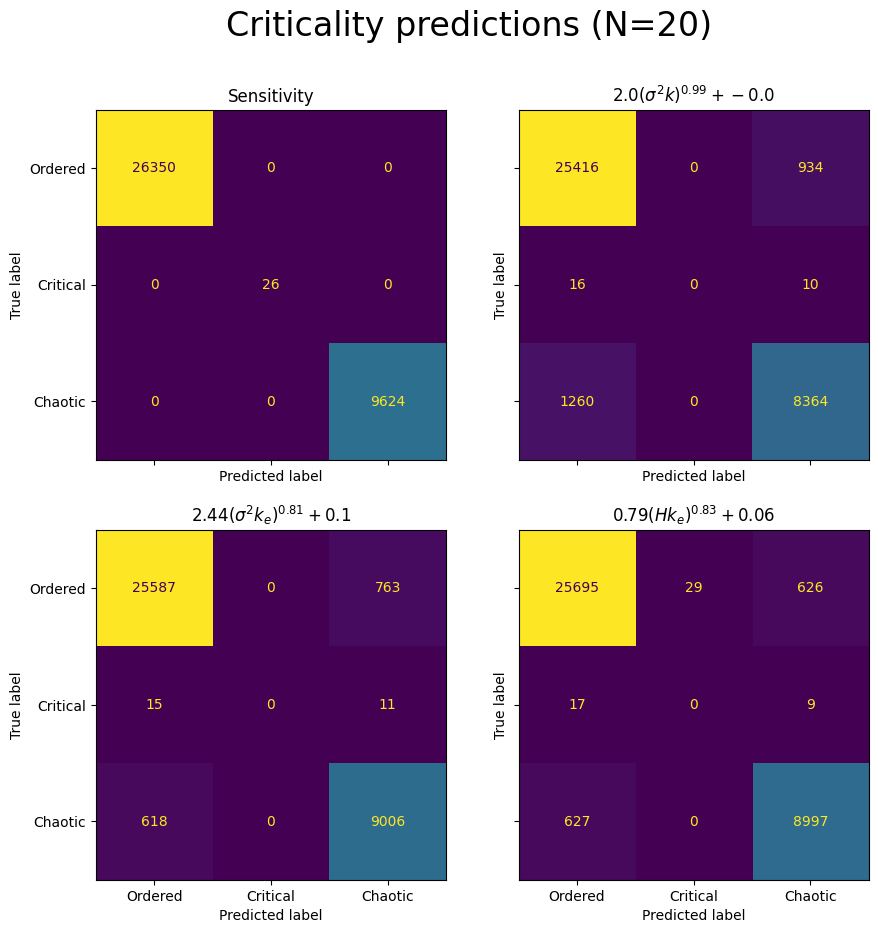

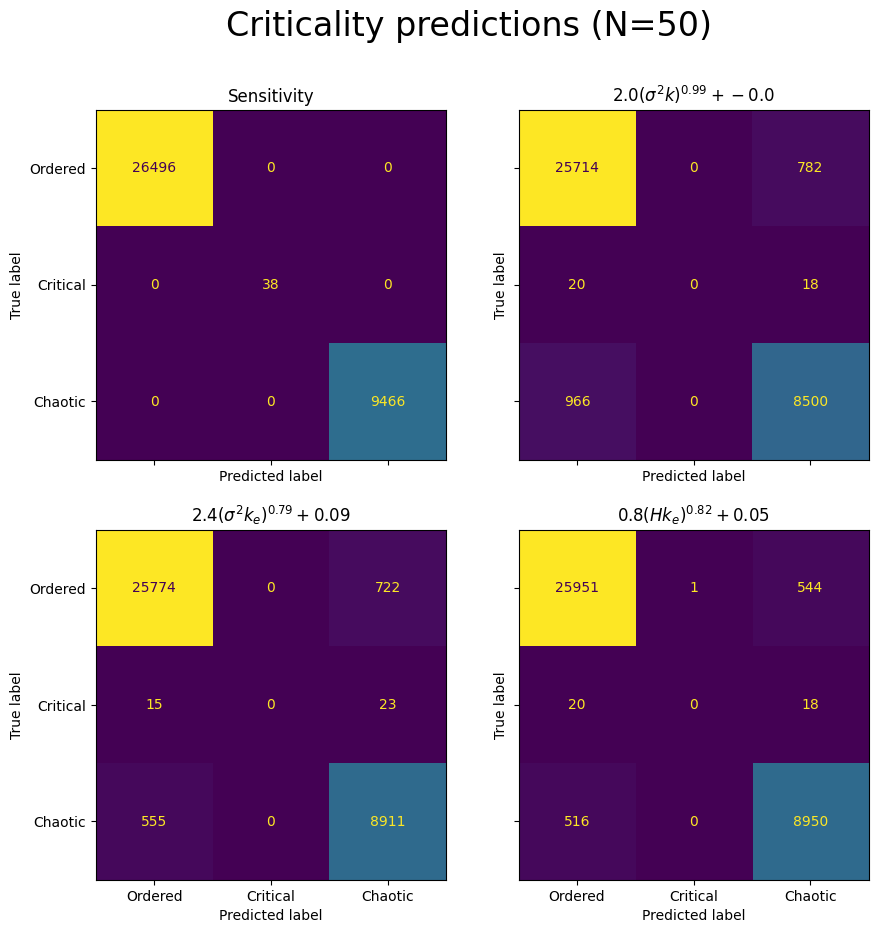

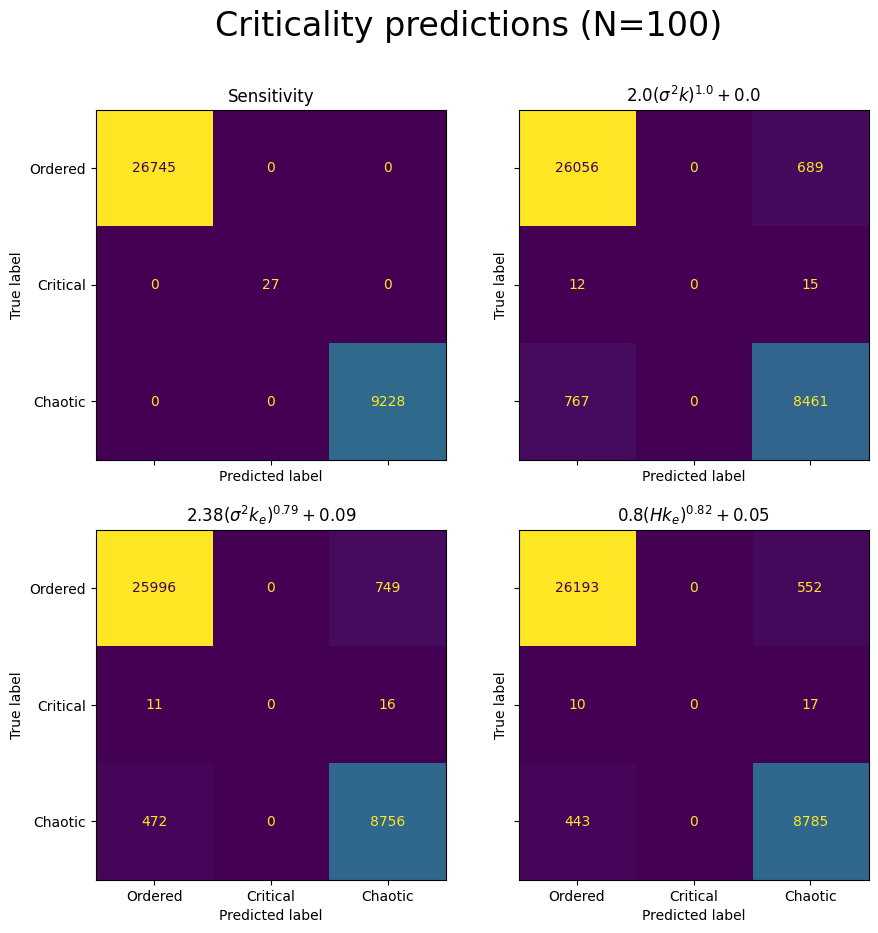

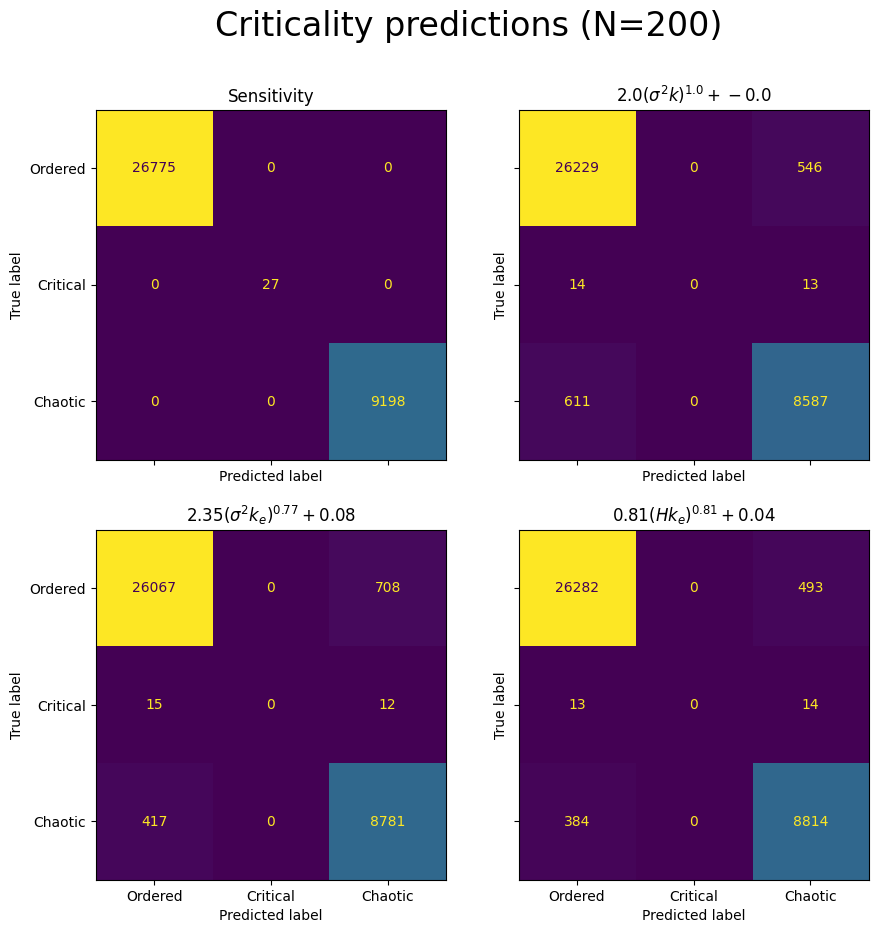

In [10]:
fs = 24
for N in Nvals:
    dfN = dfall[dfall['N']==N]
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey='row', sharex='col', facecolor='white')
    cmap = plt.cm.get_cmap('coolwarm')#.reversed()
    
    #x=dfN['avgS']
    x=dfN['Derrida']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    yfit=powerlaw(x,1,1,0)
    truth = (y>1).astype(int) - (y<1).astype(int)
    preds = (yfit>1).astype(int)-(yfit<1).astype(int)
    confusion_matrix = metrics.confusion_matrix(truth,preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Ordered', 'Critical', 'Chaotic'])
    cm_display.plot(ax=ax[0,0])
    cm_display.im_.colorbar.remove()
    ax[0,0].set_title('Sensitivity')
    
    x=dfN['avgK']*dfN['avgV']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    yfit=powerlaw(x,c,m,b)
    truth = (y>1).astype(int) - (y<1).astype(int)
    preds = (yfit>1).astype(int)-(yfit<1).astype(int)
    confusion_matrix = metrics.confusion_matrix(truth,preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Ordered', 'Critical', 'Chaotic'])
    cm_display.plot(ax=ax[0,1])
    cm_display.im_.colorbar.remove()
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k)^{mstr}+{np.round(b,2)}$'
    ax[0,1].set_title(label)
    
    x=dfN['avgKe']*dfN['avgV']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    yfit=powerlaw(x,c,m,b)
    truth = (y>1).astype(int) - (y<1).astype(int)
    preds = (yfit>1).astype(int)-(yfit<1).astype(int)
    confusion_matrix = metrics.confusion_matrix(truth,preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Ordered', 'Critical', 'Chaotic'])
    cm_display.plot(ax=ax[1,0])
    cm_display.im_.colorbar.remove()
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k_e)^{mstr}+{np.round(b,2)}$'
    ax[1,0].set_title(label)
    
    x=dfN['avgKe']*dfN['avgH']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    yfit=powerlaw(x,c,m,b)
    truth = (y>1).astype(int) - (y<1).astype(int)
    preds = (yfit>1).astype(int)-(yfit<1).astype(int)
    confusion_matrix = metrics.confusion_matrix(truth,preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Ordered', 'Critical', 'Chaotic'])
    cm_display.plot(ax=ax[1,1])
    cm_display.im_.colorbar.remove()
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(H k_e)^{mstr}+{np.round(b,2)}$'
    ax[1,1].set_title(label)
    
    fig.suptitle(f'Criticality predictions ({N=})',fontsize=fs)
    plt.savefig(f'figures/PowerLawConfusion_RBN_{N}.pdf',bbox_inches='tight')
    plt.savefig(f'figures/PowerLawConfusion_RBN_{N}.png',bbox_inches='tight')
    plt.show()

## We now begin analysis of the Cell Collective models.
We begin by importing the data and defining the bias entropy and bias variance.

In [11]:
dfcc = pd.read_csv('cc_network_data.csv')
dfcc['avgV_est']=dfcc['biasUnweighted']*(1-dfcc['biasUnweighted'])
dfcc['avgH_est']=-dfcc['biasUnweighted']*np.log2(dfcc['biasUnweighted'])-(1-dfcc['biasUnweighted'])*np.log2(1-dfcc['biasUnweighted'])

#### We will need a helper function for optimizing the critical boundary.

In [12]:
def optimize_cut(x,truth,method='Cohen kappa'):
    best_score = 0
    best_cut = 0
    for cut in sorted(x):
        cpreds = (x > cut)
        tp = np.sum(cpreds & truth)
        fp = np.sum(cpreds & ~truth)
        tn = np.sum(~cpreds & ~truth)
        fn = np.sum(~cpreds & truth)
        
        if method == 'MCC':
            denom = np.sqrt((tn+fn)*(fp+tp)*(tn+fp)*(fn+tp))
            if denom == 0:
                continue
            score = (tn*tp-fp*fn)/denom
        
        elif method == 'Accuracy':
            score = (tp+tn)/(tp+tn+fn+fp)
        
        elif method == 'Cohen kappa':
            denom = (tp+fp)*(fp+tn)+(tp+fn)*(fn+tn)
            if denom == 0:
                continue
            score = 2*(tp*tn-fn*fp)/denom
        else:
            raise ValueError
        if score > best_score:
            best_score = score
            best_cut = cut
            preds = np.copy(cpreds)
    return preds, best_cut, best_score

#### We examine some summary statistics of the Cell Collective networks.

In [13]:
print('average number of nodes:', dfcc['Nnodes'].mean())
print('Derrida coefficient quartiles:', np.percentile(dfcc['dc'], [0, 25, 50, 75, 100]))
print('Derrida coefficient mean and standard deviation:', dfcc['dc'].mean(), ',',  dfcc['dc'].std())

average number of nodes: 46.78378378378378
Derrida coefficient quartiles: [0.7055    0.9470625 0.9793125 1.0119375 1.249    ]
Derrida coefficient mean and standard deviation: 0.9736300675675675 , 0.08681282869300079


#### We highlight that sensitivity and the Derrida coefficient are in good agreement in these models.

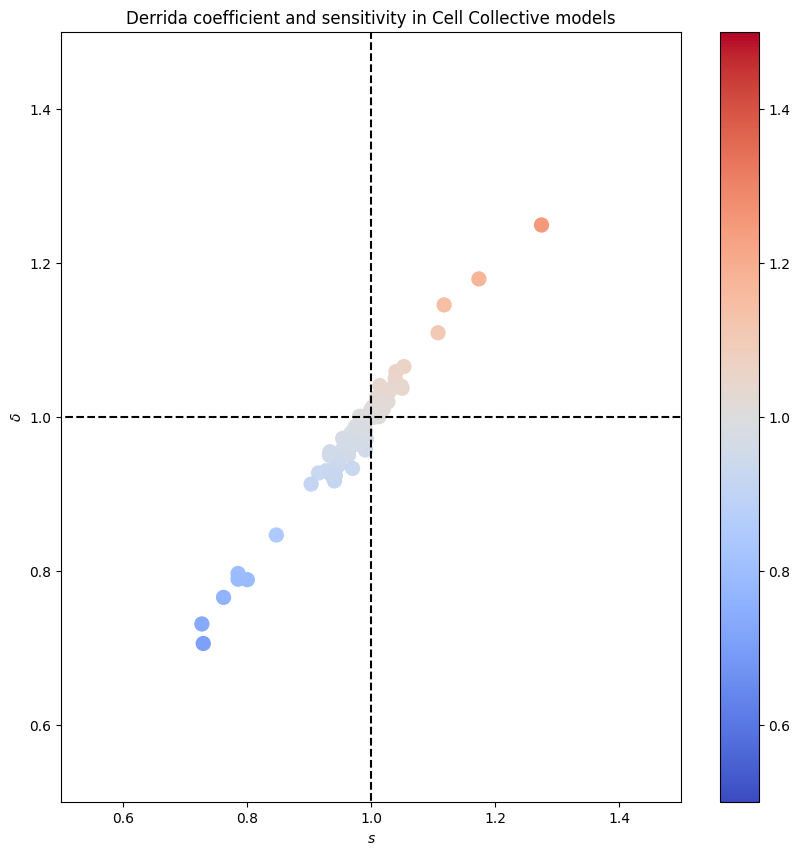

In [14]:
fig, ax = plt.subplots(figsize=(10, 10),facecolor='white')
ax.set_facecolor('white')
varx = 's'
vary = 'dc'
cmap = plt.cm.get_cmap('coolwarm')#.reversed()
sc=ax.scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax.vlines(1.0,0,2,label='$s=1$',color='k',linestyles='--')
ax.hlines(1.0,0,2,label='$\delta=1$',color='k',linestyles='--')
ax.set_ylim(0.5,1.5)
ax.set_xlim(0.5,1.5)
plt.colorbar(sc)
plt.xlabel('$s$')
plt.ylabel('$\delta$')
plt.title('Derrida coefficient and sensitivity in Cell Collective models')
#plt.legend()
plt.savefig(f'figures/DerridaSensitivity_CC.pdf',bbox_inches='tight')
plt.savefig(f'figures/DerridaSensitivity_CC.png',bbox_inches='tight')
plt.show()

#### We show the dependence of $\delta$ and $s$ on the connectivity-spread products considered earlier.
We highlight a critical region between dotted lines. This region is centered on $\delta=1$ and has width equal to the width of the IQR of the $\delta$ distribution.

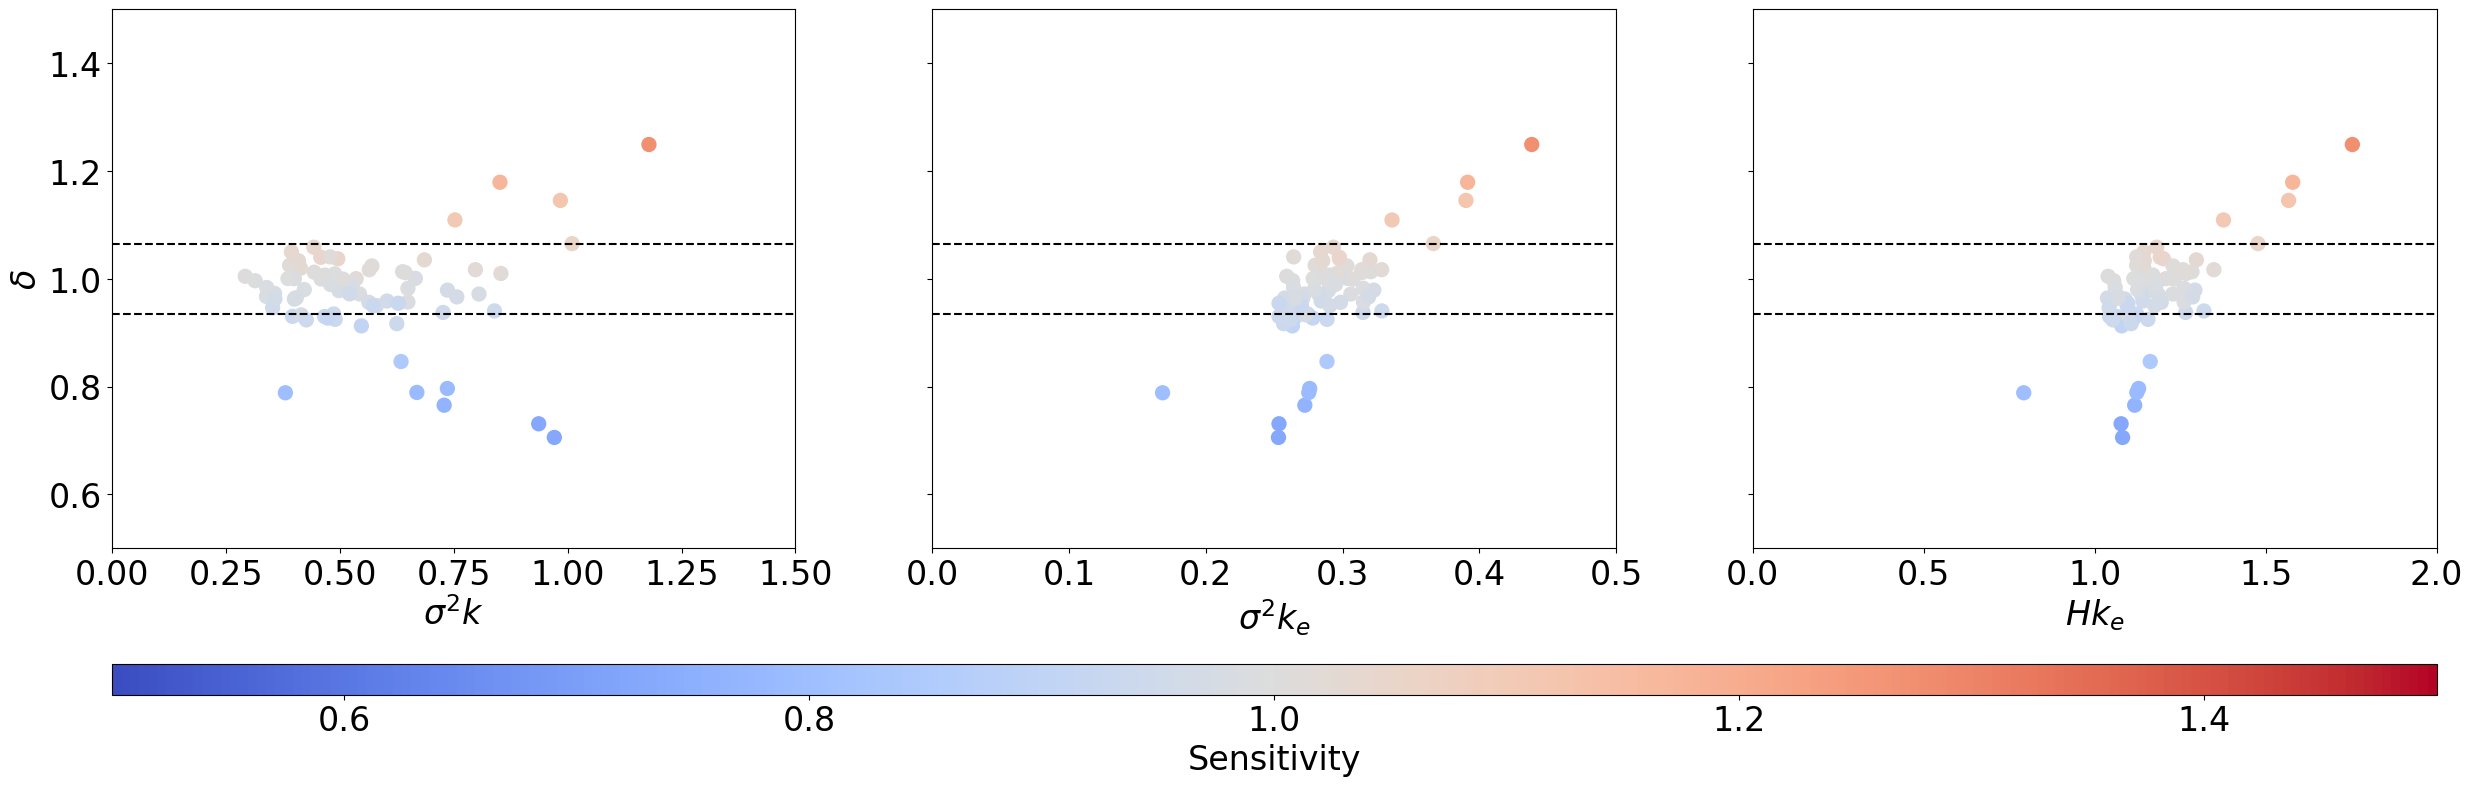

In [15]:
fs = 24
fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white',sharey='row')
cmap = plt.cm.get_cmap('coolwarm')

dd=np.subtract(*np.percentile(dfcc['dc'], [75, 25]))
sc=ax[0].scatter(dfcc['avgV_est']*dfcc['k'],dfcc['dc'],s=100,c=dfcc['s'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax[0].set_ylim(0.5,1.5)
ax[0].set_xlim(0,1.5)
#ax[0].legend(loc='upper left',fontsize=fs)
ax[0].set_xlabel('$\sigma^2 k$',fontsize=fs)
ax[0].set_ylabel('$\delta$',fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=fs)
ax[0].hlines([1-dd,1+dd],xmin=0,xmax=1.5,colors='k',linestyles='--')

sc=ax[1].scatter(dfcc['avgV_est']*dfcc['ke'],dfcc['dc'],s=100,c=dfcc['s'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax[1].set_ylim(0.5,1.5)
ax[1].set_xlim(0,0.5)
#ax[1].legend(loc='upper left',fontsize=fs)
ax[1].set_xlabel('$\sigma^2 k_e$',fontsize=fs)
#ax[1].set_ylabel('$\delta$',fontsize=fs)
ax[1].tick_params(axis='both', which='major', labelsize=fs)
ax[1].hlines([1-dd,1+dd],xmin=0,xmax=0.5,colors='k',linestyles='--')

sc=ax[2].scatter(dfcc['avgH_est']*dfcc['ke'],dfcc['dc'],s=100,c=dfcc['s'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax[2].set_ylim(0.5,1.5)
ax[2].set_xlim(0,2)
#ax[2].legend(loc='upper left',fontsize=fs)
ax[2].set_xlabel('$H k_e$',fontsize=fs)
#ax[2].set_ylabel('$\delta$',fontsize=fs)
ax[2].tick_params(axis='both', which='major', labelsize=fs)
ax[2].hlines([1-dd,1+dd],xmin=0,xmax=2,colors='k',linestyles='--')

cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
cbar.ax.tick_params(axis='both',labelsize=fs)
cbar.set_label('Sensitivity',fontsize=fs)

plt.savefig(f'figures/DerridaConnectivitySpread_CC_from_bias.pdf',bbox_inches='tight')
plt.savefig(f'figures/DerridaConnectivitySpread_CC_from_bias.png',bbox_inches='tight')
plt.show()


#### Next, we attempt to find the optimal critical boundary according to various measures.

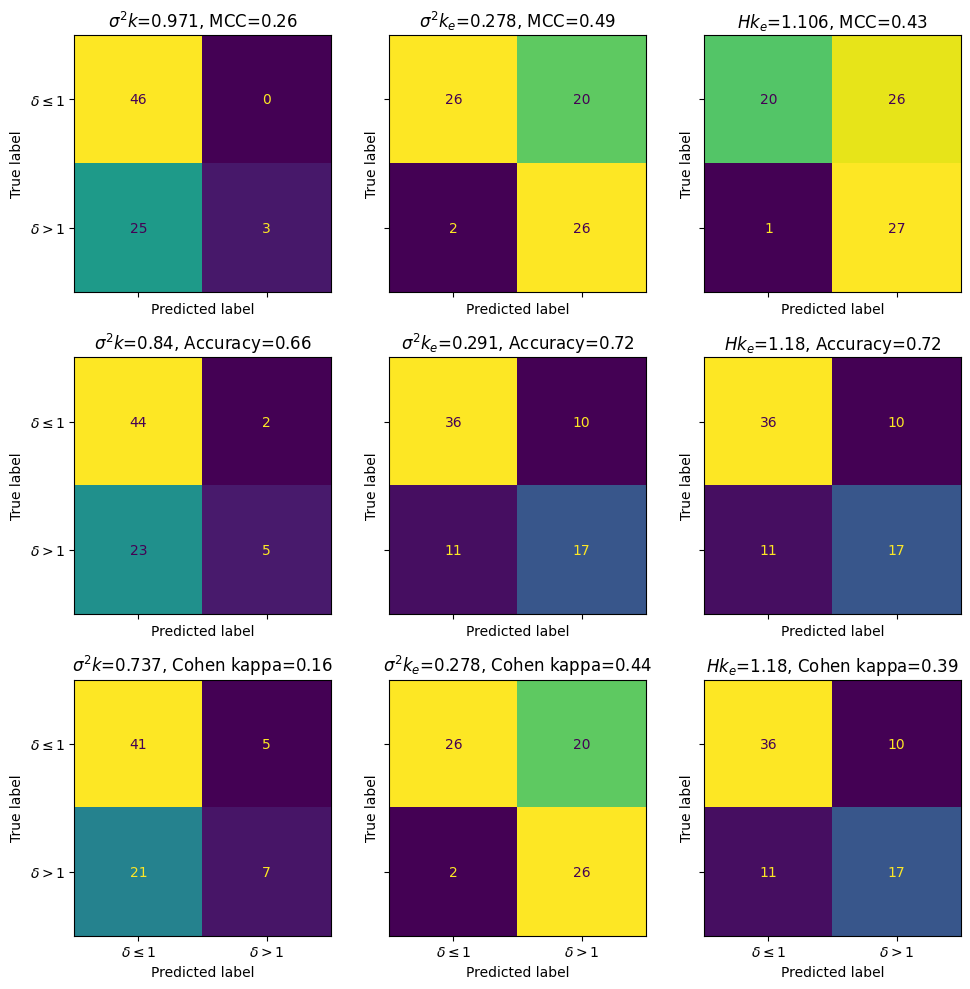

In [16]:
fs = 24
fig, ax = plt.subplots(3,3, figsize=(
        10, 10), sharey='row', sharex='col', facecolor='white')
truth = (dfcc['dc'] > 1)
for row, method in enumerate(['MCC','Accuracy','Cohen kappa']):

    x = dfcc['k']*dfcc['avgV_est']
    preds,cut,score=optimize_cut(x,truth,method=method)
    confusion_matrix = metrics.confusion_matrix(truth, preds)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=['$\delta \leq 1$', '$\delta > 1$'])
    cm_display.plot(ax=ax[row,0])
    cm_display.im_.colorbar.remove()
    mstr = '{'+str(np.round(m, 2))+'}'
    label = f'$\sigma^2 k$={np.round(cut,3)}, {method}={np.round(score,2)}'
    ax[row,0].set_title(label)

    x = dfcc['ke']*dfcc['avgV_est']
    preds,cut,score=optimize_cut(x,truth,method=method)
    confusion_matrix = metrics.confusion_matrix(truth, preds)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=['$\delta \leq 1$', '$\delta > 1$'])
    cm_display.plot(ax=ax[row,1])
    cm_display.im_.colorbar.remove()
    mstr = '{'+str(np.round(m, 2))+'}'
    label = f'$\sigma^2 k_e$={np.round(cut,3)}, {method}={np.round(score,2)}'
    ax[row,1].set_title(label)

    x = dfcc['ke']*dfcc['avgH_est']
    preds,cut,score=optimize_cut(x,truth,method=method)
    confusion_matrix = metrics.confusion_matrix(truth, preds)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=['$\delta \leq 1$', '$\delta > 1$'])
    cm_display.plot(ax=ax[row,2])
    cm_display.im_.colorbar.remove()
    mstr = '{'+str(np.round(m, 2))+'}'
    label = f'$H k_e$={np.round(cut,3)}, {method}={np.round(score,2)}'
    ax[row,2].set_title(label)


fig.tight_layout()
plt.savefig(f'figures/ConfusionOptimized_CC_from_bias.png',bbox_inches='tight')
plt.savefig(f'figures/ConfusionOptimized_CC_from_bias.pdf',bbox_inches='tight')
plt.show()

We will record the values that give rise to the greatest accuracy.

In [17]:
acut_KV_fb = 0.84
acut_KeV_fb = 0.291
acut_KeH_fb = 1.18

#### We now compare these optimal boundaries to the ones obtained from the RBN ensemble.

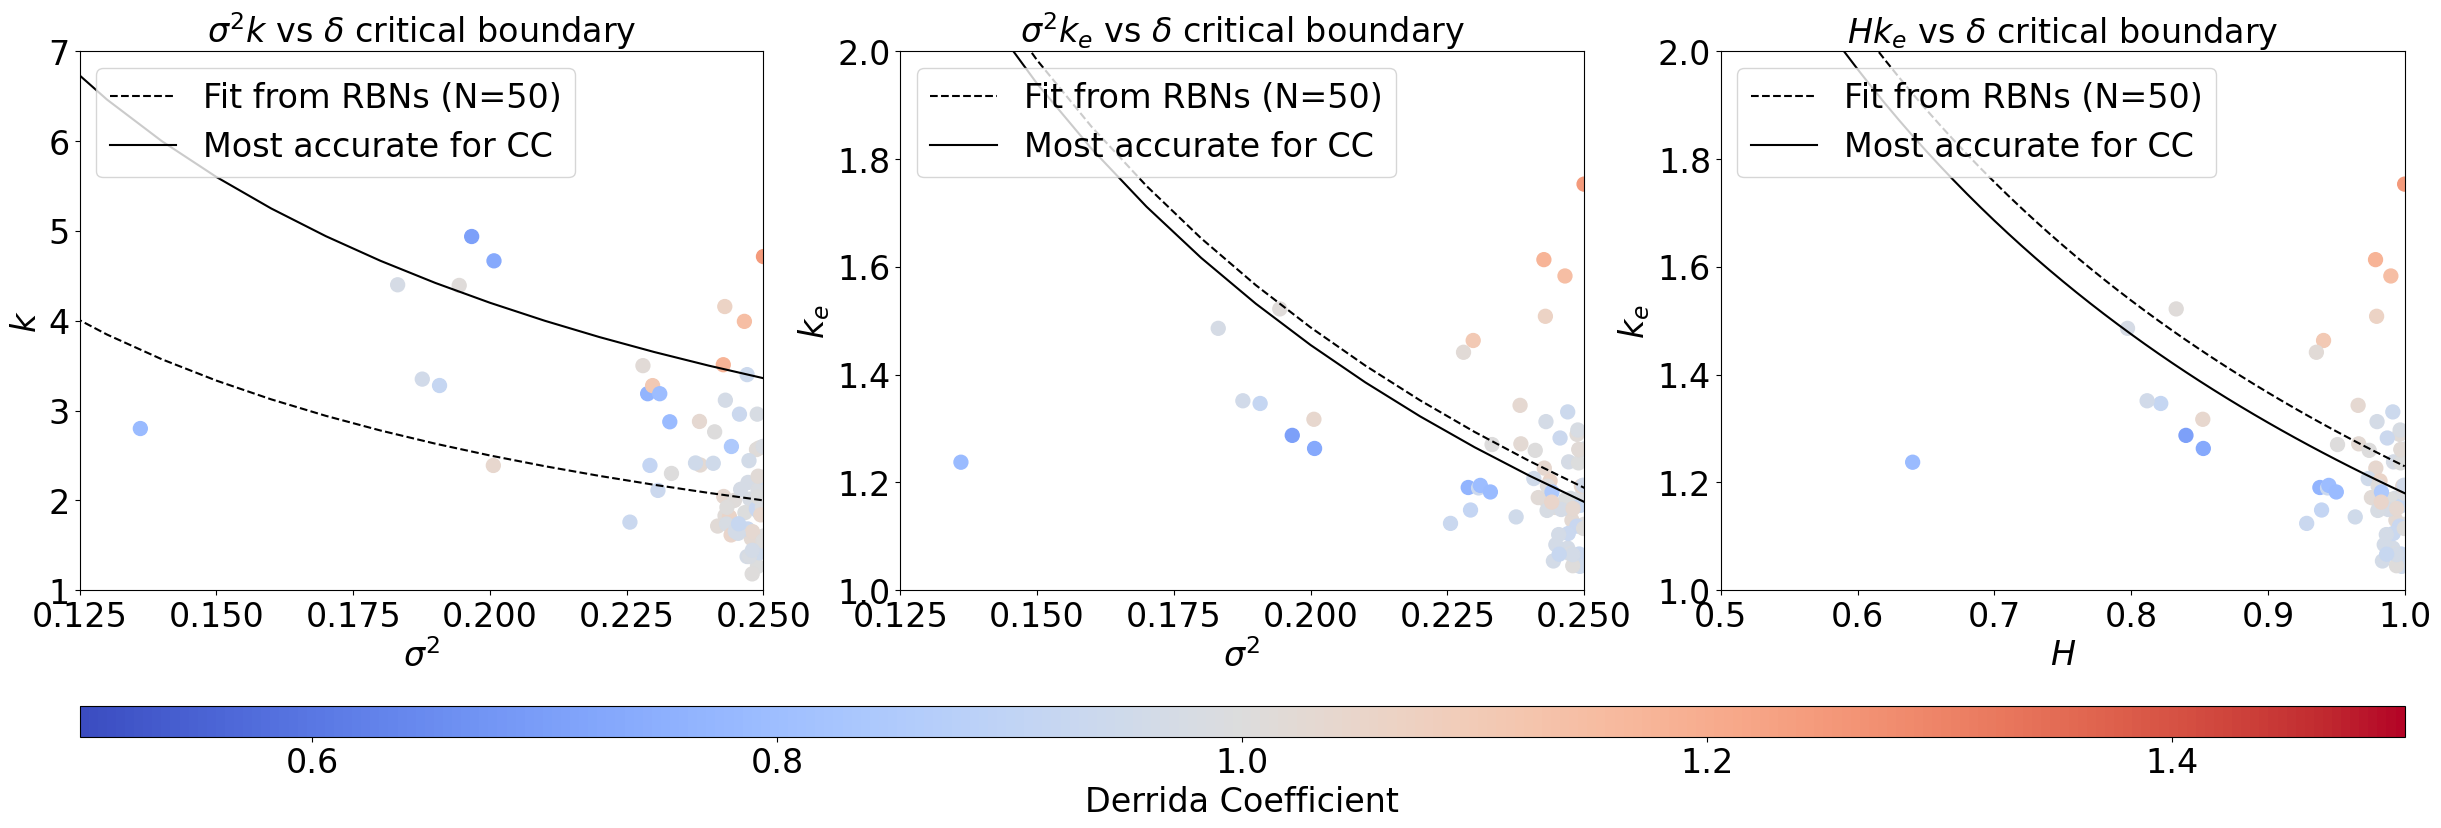

In [18]:
fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
bounds = ([0,0,-10],[10,10,10]) #c,m,b
fs = 24
cmap = plt.cm.get_cmap('coolwarm')

varx = 'avgV_est'
vary = 'k'

sc=ax[0].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
px = np.arange(0.01,1,0.01)
py=acut_KV_fb/px
py2=critical_kappa(px,2,1,0)
ax[0].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[0].plot(px,py,'-k',label='Most accurate for CC')
ax[0].set_ylim(1,7)
ax[0].set_xlim(0.125,0.25)
ax[0].legend(loc='upper left',fontsize=fs)
ax[0].set_xlabel('$\sigma^2$',fontsize=fs)
ax[0].set_ylabel('$k$',fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=fs)
ax[0].set_title('$\sigma^2 k$ vs $\delta$ critical boundary',fontsize=fs)

varx = 'avgV_est'
vary = 'ke'

sc=ax[1].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
px = np.arange(0.01,1,0.01)
py=acut_KeV_fb/px
py2=critical_kappa(px,2.4,0.8,0.09)
ax[1].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[1].plot(px,py,'-k',label='Most accurate for CC')
ax[1].set_ylim(1,2)
ax[1].set_xlim(0.125,0.25)
ax[1].legend(loc='upper left',fontsize=fs)
ax[1].set_xlabel('$\sigma^2$',fontsize=fs)
ax[1].set_ylabel('$k_e$',fontsize=fs)
ax[1].tick_params(axis='both', which='major', labelsize=fs)
ax[1].set_title('$\sigma^2 k_e$ vs $\delta$ critical boundary',fontsize=fs)

varx = 'avgH_est'
vary = 'ke'

sc=ax[2].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0,label=None)
px = np.arange(0.01,1.01,0.01)
py=acut_KeH_fb/px
py2=critical_kappa(px,0.8,0.83,0.05)
ax[2].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[2].plot(px,py,'-k',label='Most accurate for CC')
ax[2].set_ylim(1,2)
ax[2].set_xlim(0.5,1)
ax[2].legend(loc='upper left',fontsize=fs)
ax[2].set_xlabel('$H$',fontsize=fs)
ax[2].set_ylabel('$k_e$',fontsize=fs)
ax[2].tick_params(axis='both', which='major', labelsize=fs)
ax[2].set_title('$H k_e$ vs $\delta$ critical boundary',fontsize=fs)

cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
cbar.ax.tick_params(axis='both',labelsize=fs)
cbar.set_label('Derrida Coefficient',fontsize=fs)

plt.savefig(f'figures/PowerLawFits_CC_from_bias.pdf',bbox_inches='tight')
plt.savefig(f'figures/PowerLawFits_CC_from_bias.png',bbox_inches='tight')
plt.show()

#### We now consider an alternate averaging scheme for the Cell Collective models.
The theory of RBNs considers $\sigma^2$ as computed from the overall bias of the network, rather than computed from the average of each node's output variance. This traditional approach gives rise to the classical results in the theory. However, the second, less-convential approach we propose here performs better in the Cell Collective (especially when paired with effective connectivity), as we will demonstrate. We use the prime to denote that the parameters are computed using this alternate averaging scheme.

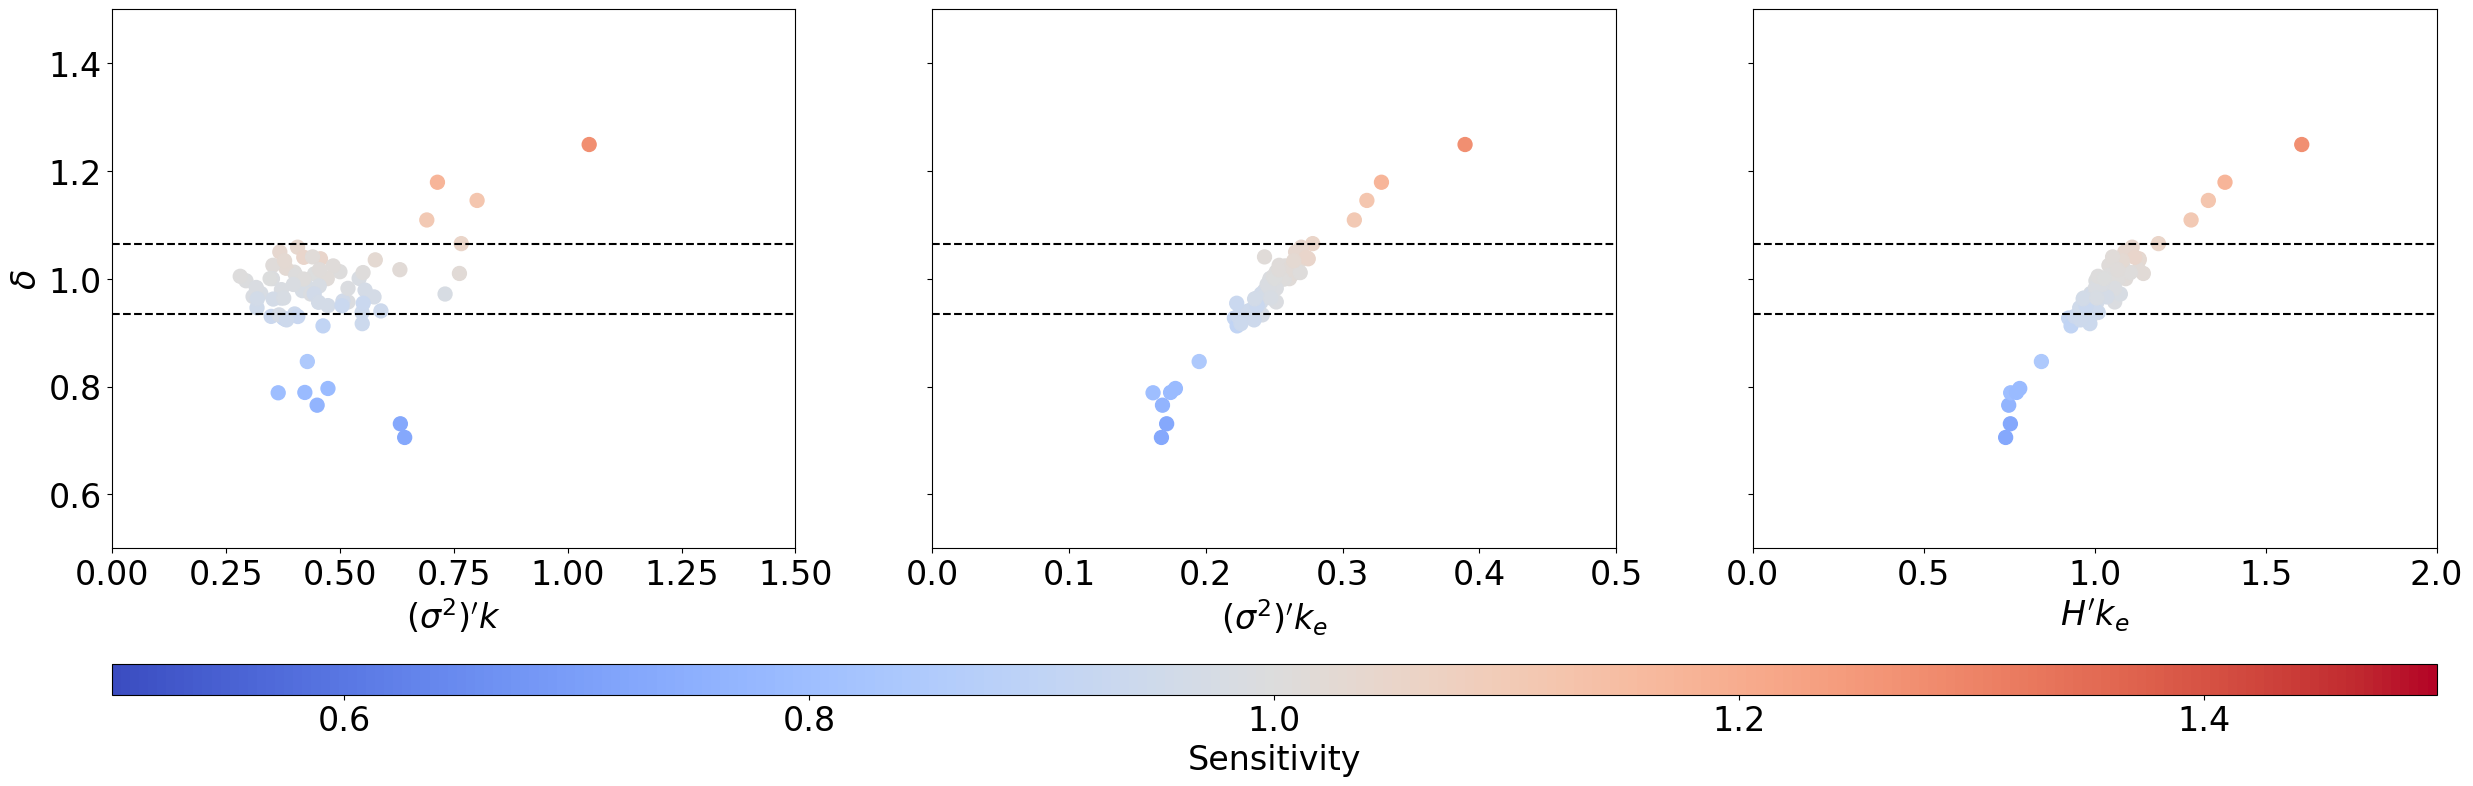

In [19]:
fs = 24
fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white',sharey='row')
cmap = plt.cm.get_cmap('coolwarm')

dd=np.subtract(*np.percentile(dfcc['dc'], [75, 25]))
sc=ax[0].scatter(dfcc['avgV']*dfcc['k'],dfcc['dc'],s=100,c=dfcc['s'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax[0].set_ylim(0.5,1.5)
ax[0].set_xlim(0,1.5)
ax[0].set_xlabel('$(\sigma^2)^\prime k$',fontsize=fs)
ax[0].set_ylabel('$\delta$',fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=fs)
ax[0].hlines([1-dd,1+dd],xmin=0,xmax=1.5,colors='k',linestyles='--')

sc=ax[1].scatter(dfcc['avgV']*dfcc['ke'],dfcc['dc'],s=100,c=dfcc['s'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax[1].set_ylim(0.5,1.5)
ax[1].set_xlim(0,0.5)
ax[1].set_xlabel('$(\sigma^2)^\prime k_e$',fontsize=fs)
ax[1].tick_params(axis='both', which='major', labelsize=fs)
ax[1].hlines([1-dd,1+dd],xmin=0,xmax=0.5,colors='k',linestyles='--')

sc=ax[2].scatter(dfcc['avgH']*dfcc['ke'],dfcc['dc'],s=100,c=dfcc['s'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax[2].set_ylim(0.5,1.5)
ax[2].set_xlim(0,2)
ax[2].set_xlabel('$H^\prime k_e$',fontsize=fs)
ax[2].tick_params(axis='both', which='major', labelsize=fs)
ax[2].hlines([1-dd,1+dd],xmin=0,xmax=2,colors='k',linestyles='--')

cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
cbar.ax.tick_params(axis='both',labelsize=fs)
cbar.set_label('Sensitivity',fontsize=fs)

plt.savefig(f'figures/DerridaConnectivitySpread_CC.pdf',bbox_inches='tight')
plt.savefig(f'figures/DerridaConnectivitySpread_CC.png',bbox_inches='tight')
plt.show()


The first indication that the alternate averaging scheme is more appropriate in this setting is the qualitatively improved correlation relative to the previously explored averaging scheme.

#### We now optimize the critical boundaries using the parameters above.

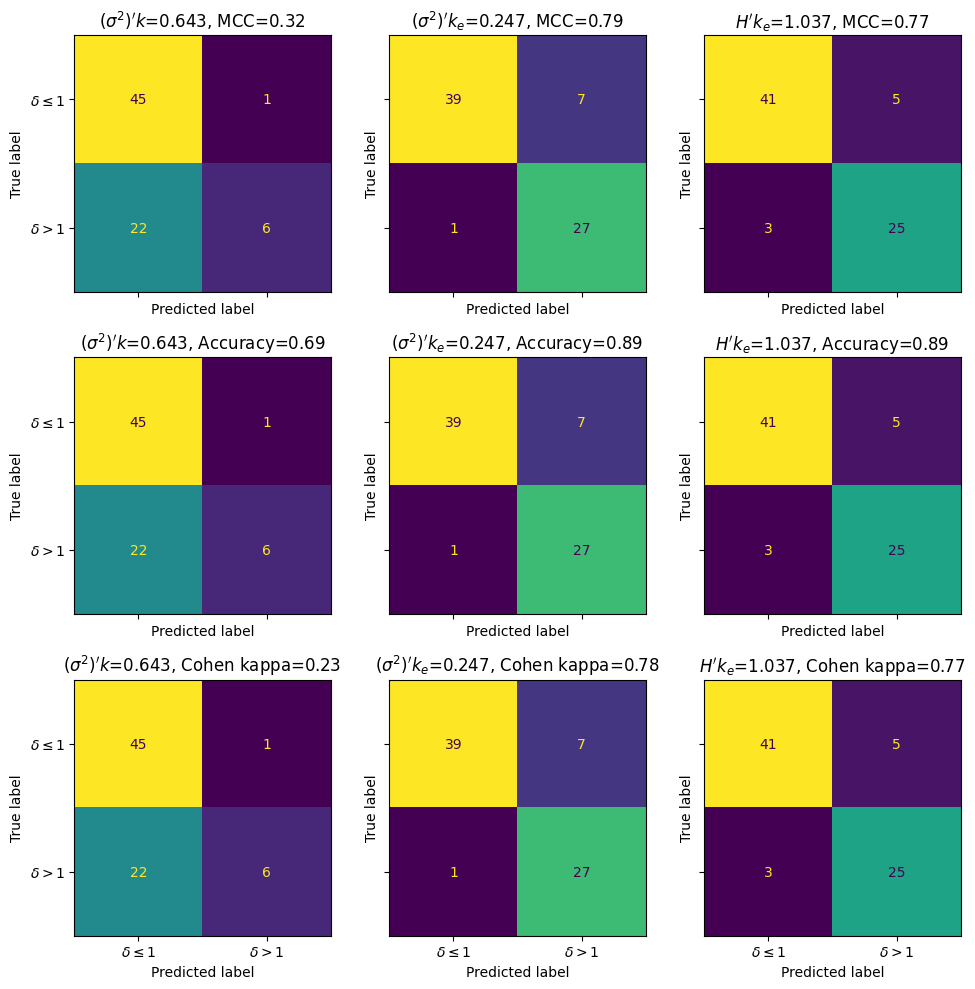

In [20]:
fs = 24
fig, ax = plt.subplots(3,3, figsize=(
        10, 10), sharey='row', sharex='col', facecolor='white')
truth = (dfcc['dc'] > 1)
for row, method in enumerate(['MCC','Accuracy','Cohen kappa']):

    x = dfcc['k']*dfcc['avgV']
    preds,cut,score=optimize_cut(x,truth,method=method)
    confusion_matrix = metrics.confusion_matrix(truth, preds)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=['$\delta \leq 1$', '$\delta > 1$'])
    cm_display.plot(ax=ax[row,0])
    cm_display.im_.colorbar.remove()
    mstr = '{'+str(np.round(m, 2))+'}'
    label = f'$(\sigma^2)^\prime k$={np.round(cut,3)}, {method}={np.round(score,2)}'
    ax[row,0].set_title(label)

    x = dfcc['ke']*dfcc['avgV']
    preds,cut,score=optimize_cut(x,truth,method=method)
    confusion_matrix = metrics.confusion_matrix(truth, preds)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=['$\delta \leq 1$', '$\delta > 1$'])
    cm_display.plot(ax=ax[row,1])
    cm_display.im_.colorbar.remove()
    mstr = '{'+str(np.round(m, 2))+'}'
    label = f'$(\sigma^2)^\prime k_e$={np.round(cut,3)}, {method}={np.round(score,2)}'
    ax[row,1].set_title(label)

    x = dfcc['ke']*dfcc['avgH']
    preds,cut,score=optimize_cut(x,truth,method=method)
    confusion_matrix = metrics.confusion_matrix(truth, preds)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=['$\delta \leq 1$', '$\delta > 1$'])
    cm_display.plot(ax=ax[row,2])
    cm_display.im_.colorbar.remove()
    mstr = '{'+str(np.round(m, 2))+'}'
    label = f'$H^\prime k_e$={np.round(cut,3)}, {method}={np.round(score,2)}'
    ax[row,2].set_title(label)


fig.tight_layout()
plt.savefig(f'figures/ConfusionOptimized_CC.png',bbox_inches='tight')
plt.savefig(f'figures/ConfusionOptimized_CC.pdf',bbox_inches='tight')
plt.show()

We record the most accurate thresholds (which also optimize all other metrics considered, in this case).

In [21]:
acut_KV = 0.643
acut_KeV = 0.247
acut_KeH = 1.037

#### We now plot the critical boundaries we have obtained via the optimization above.

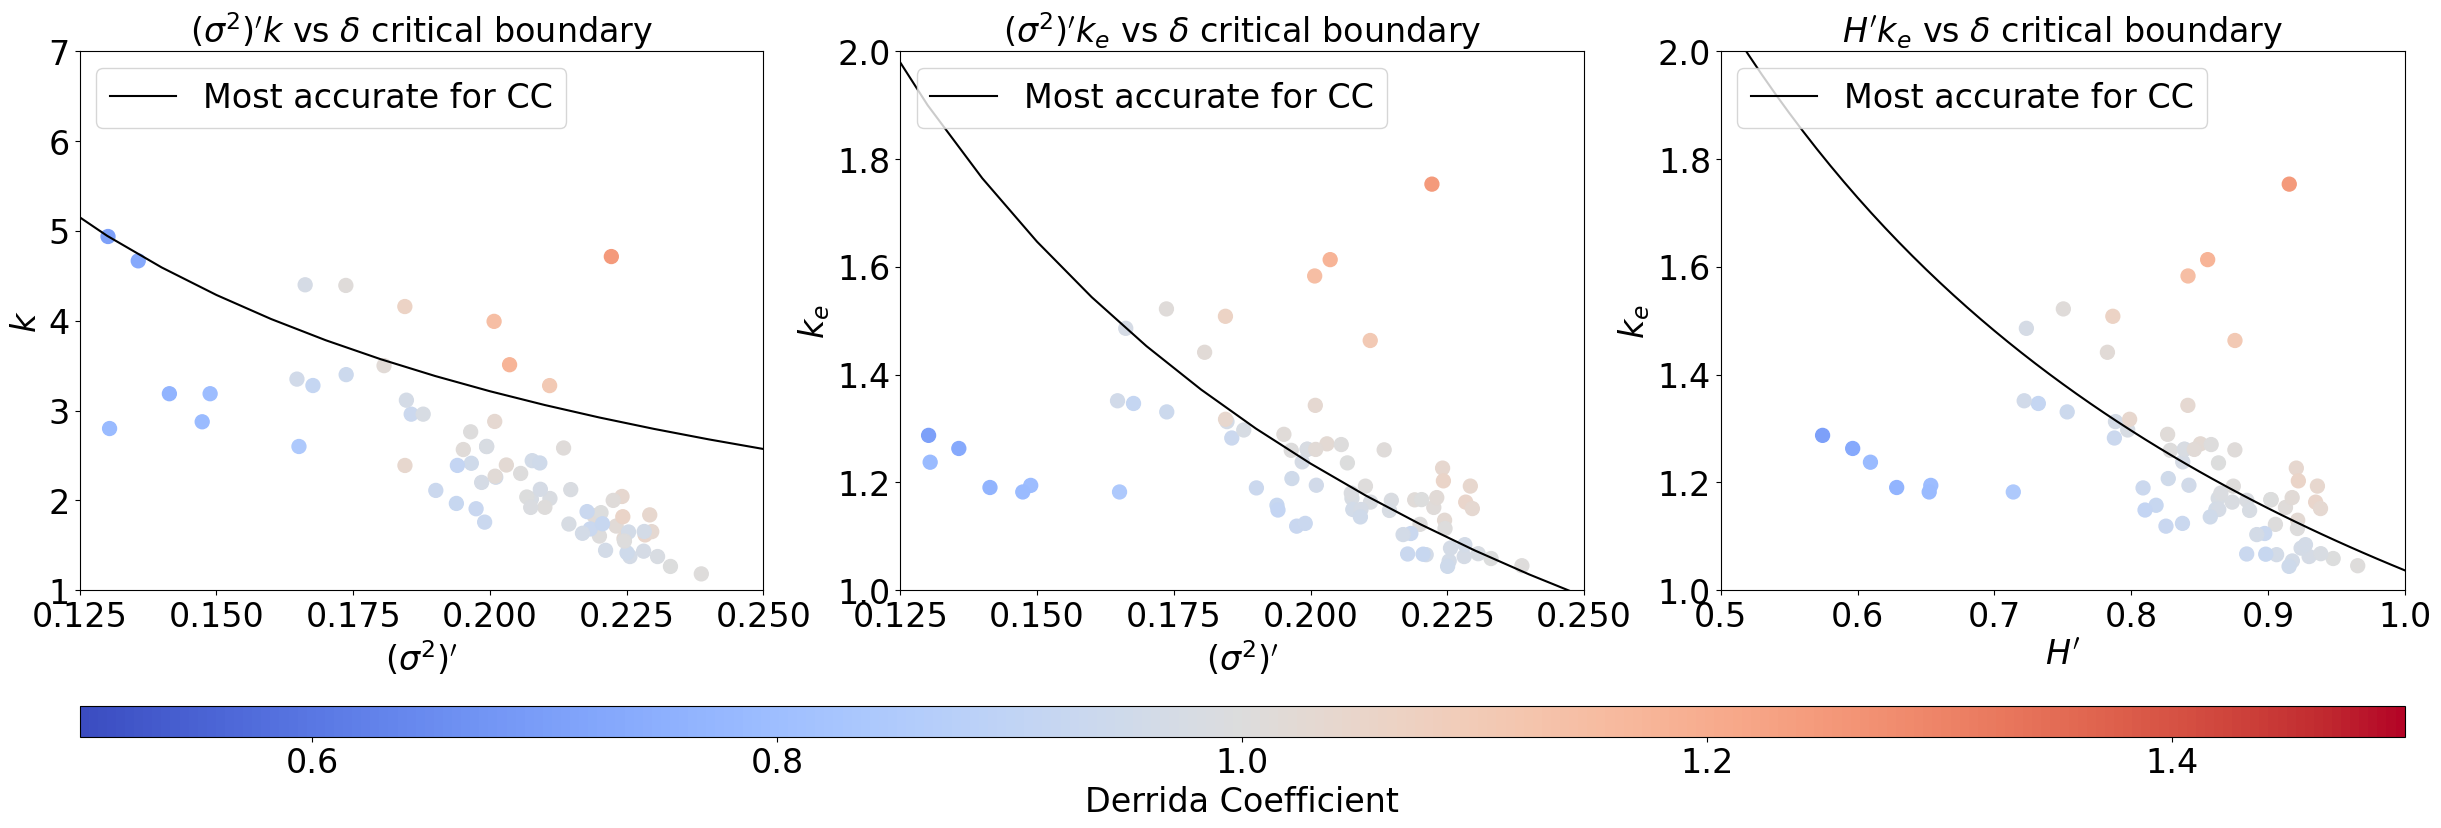

In [22]:
fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
bounds = ([0,0,-10],[10,10,10]) #c,m,b
fs = 24
cmap = plt.cm.get_cmap('coolwarm')

varx = 'avgV'
vary = 'k'

sc=ax[0].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
px = np.arange(0.01,1,0.01)
py=acut_KV/px
ax[0].plot(px,py,'-k',label='Most accurate for CC')
ax[0].set_ylim(1,7)
ax[0].set_xlim(0.125,0.25)
ax[0].legend(loc='upper left',fontsize=fs)
ax[0].set_xlabel('$(\sigma^2)^\prime$',fontsize=fs)
ax[0].set_ylabel('$k$',fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=fs)
ax[0].set_title('$(\sigma^2)^\prime k$ vs $\delta$ critical boundary',fontsize=fs)

varx = 'avgV'
vary = 'ke'

sc=ax[1].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
px = np.arange(0.01,1,0.01)
py=acut_KeV/px
ax[1].plot(px,py,'-k',label='Most accurate for CC')
ax[1].set_ylim(1,2)
ax[1].set_xlim(0.125,0.25)
ax[1].legend(loc='upper left',fontsize=fs)
ax[1].set_xlabel('$(\sigma^2)^\prime$',fontsize=fs)
ax[1].set_ylabel('$k_e$',fontsize=fs)
ax[1].tick_params(axis='both', which='major', labelsize=fs)
ax[1].set_title('$(\sigma^2)^\prime k_e$ vs $\delta$ critical boundary',fontsize=fs)

varx = 'avgH'
vary = 'ke'

sc=ax[2].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0,label=None)
px = np.arange(0.01,1.01,0.01)
py=acut_KeH/px
ax[2].plot(px,py,'-k',label='Most accurate for CC')
ax[2].set_ylim(1,2)
ax[2].set_xlim(0.5,1)
ax[2].legend(loc='upper left',fontsize=fs)
ax[2].set_xlabel('$H^\prime$',fontsize=fs)
ax[2].set_ylabel('$k_e$',fontsize=fs)
ax[2].tick_params(axis='both', which='major', labelsize=fs)
ax[2].set_title('$H^\prime k_e$ vs $\delta$ critical boundary',fontsize=fs)

cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
cbar.ax.tick_params(axis='both',labelsize=fs)
cbar.set_label('Derrida Coefficient',fontsize=fs)

plt.savefig(f'figures/PowerLawFits_CC.pdf',bbox_inches='tight')
plt.savefig(f'figures/PowerLawFits_CC.png',bbox_inches='tight')
plt.show()

#### We now examine how well the critical regions predicted by the fits agree with that obtained from $\delta$ directly.
The critical region here is taken to be the range of $\delta$ values (predicted by the connectivity-spread products or measured) that is centered at $\delta=1$ and has width equal to the IQR of the $\delta$ distribution (predicted or measured). We use the optimal boundaries obtained earlier.

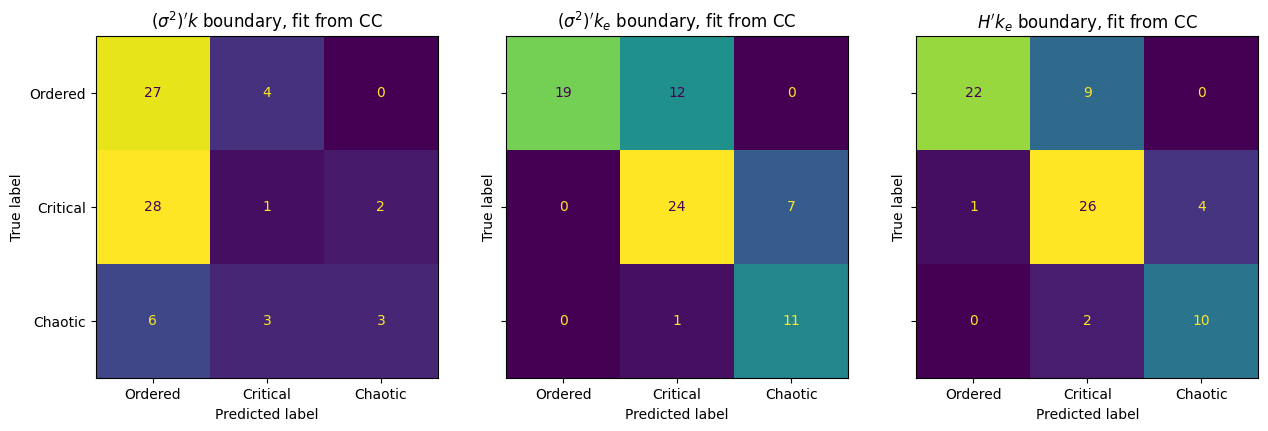

In [23]:
fs = 24

dev_frac = 2
critical_range = np.subtract(*np.percentile(dfcc['dc'], [75, 25]))/dev_frac#dfcc['dc'].std()/dev_frac  
truth = (dfcc['dc'] > (1+critical_range)).astype(int) - \
    (dfcc['dc'] < (1-critical_range)).astype(int)

fig, ax = plt.subplots(1, 3, figsize=(
    15, 10), sharey='row', sharex='col', facecolor='white')

x = dfcc['k']*dfcc['avgV']
yfit = x/acut_KV
critical_range = np.subtract(*np.percentile(yfit, [75, 25]))/dev_frac#yfit.std()/dev_frac
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[0])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$(\sigma^2)^\prime k$ boundary, fit from CC'
ax[0].set_title(label)

x = dfcc['ke']*dfcc['avgV']
yfit = x/acut_KeV
critical_range = np.subtract(*np.percentile(yfit, [75, 25]))/dev_frac#yfit.std()/dev_frac
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[1])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$(\sigma^2)^\prime k_e$ boundary, fit from CC'
ax[1].set_title(label)

x = dfcc['ke']*dfcc['avgH']
yfit = x/acut_KeH
critical_range = np.subtract(*np.percentile(yfit, [75, 25]))/dev_frac#yfit.std()/dev_frac
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[2])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$H^\prime k_e$ boundary, fit from CC'
ax[2].set_title(label)


plt.savefig(f'figures/ConfusionIQR_CC.pdf',bbox_inches='tight')
plt.savefig(f'figures/ConfusionIQR_CC.png',bbox_inches='tight')
plt.show()


#### We also explore the effect of varying the threshold for the critical boundary for the various measures.
We begin by constructing the ROCs.

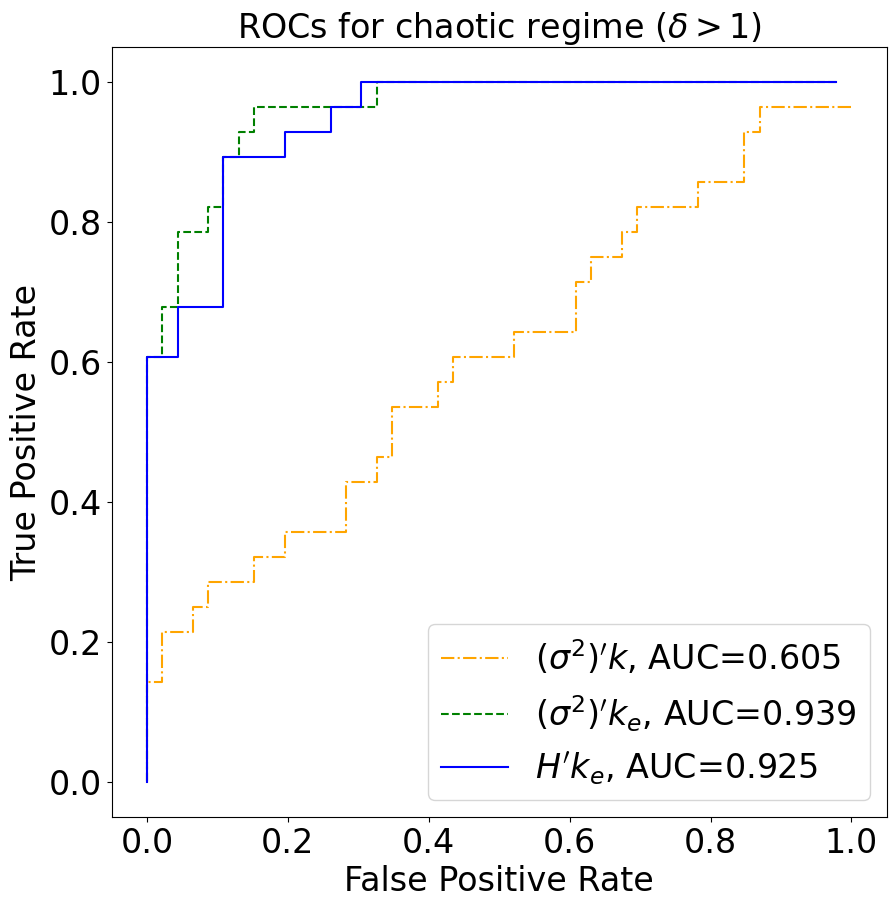

In [24]:
fs = 24
fig, ax = plt.subplots(1,1, figsize=(
        10, 10), sharey='row', sharex='col', facecolor='white')
truth = (dfcc['dc']>1)

x = dfcc['k']*dfcc['avgV']
fp = np.array([np.sum((x > cut) & ~truth) for cut in sorted(x)])
tp = np.array([np.sum((x > cut) & truth) for cut in sorted(x)])
tn = np.array([np.sum((x <= cut) & ~truth) for cut in sorted(x)])
fn = np.array([np.sum((x <= cut) & truth) for cut in sorted(x)])
fpr = fp/(tn+fp)
tpr = tp/(tp+fn)
AUC=-np.sum(tpr[0:-1]*np.diff(fpr)).round(3)
ax.plot(fpr,tpr,'-.',c='orange',label=f'$(\sigma^2)^\prime k$, {AUC=}')

x = dfcc['ke']*dfcc['avgV']
fp = np.array([np.sum((x > cut) & ~truth) for cut in sorted(x)])
tp = np.array([np.sum((x > cut) & truth) for cut in sorted(x)])
tn = np.array([np.sum((x <= cut) & ~truth) for cut in sorted(x)])
fn = np.array([np.sum((x <= cut) & truth) for cut in sorted(x)])
fpr = fp/(tn+fp)
tpr = tp/(tp+fn)
AUC=-np.sum(tpr[0:-1]*np.diff(fpr)).round(3)
ax.plot(fpr,tpr,'--',c='green',label=f'$(\sigma^2)^\prime k_e$, {AUC=}')

x = dfcc['ke']*dfcc['avgH']
fp = np.array([np.sum((x > cut) & ~truth) for cut in sorted(x)])
tp = np.array([np.sum((x > cut) & truth) for cut in sorted(x)])
tn = np.array([np.sum((x <= cut) & ~truth) for cut in sorted(x)])
fn = np.array([np.sum((x <= cut) & truth) for cut in sorted(x)])
fpr = fp/(tn+fp)
tpr = tp/(tp+fn)
AUC=-np.sum(tpr[0:-1]*np.diff(fpr)).round(3)
ax.plot(fpr,tpr,'-',c='blue',label=f'$H^\prime k_e$, {AUC=}')

ax.set_ylabel('True Positive Rate', fontsize=fs)
ax.set_xlabel('False Positive Rate', fontsize=fs)
ax.legend(fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_title('ROCs for chaotic regime ($\delta>1$)',fontsize=fs)
plt.savefig(f'figures/ROC_DC.pdf',bbox_inches='tight')
plt.savefig(f'figures/ROC_DC.png',bbox_inches='tight')
plt.show()

#### We now construct the PRCs.

C:\Users\jcroz\AppData\Local\Temp\ipykernel_5880\3623365655.py:11: RuntimeWarning: invalid value encountered in divide
  prec = tp/(tp+fp)
C:\Users\jcroz\AppData\Local\Temp\ipykernel_5880\3623365655.py:21: RuntimeWarning: invalid value encountered in divide
  prec = tp/(tp+fp)
C:\Users\jcroz\AppData\Local\Temp\ipykernel_5880\3623365655.py:31: RuntimeWarning: invalid value encountered in divide
  prec = tp/(tp+fp)


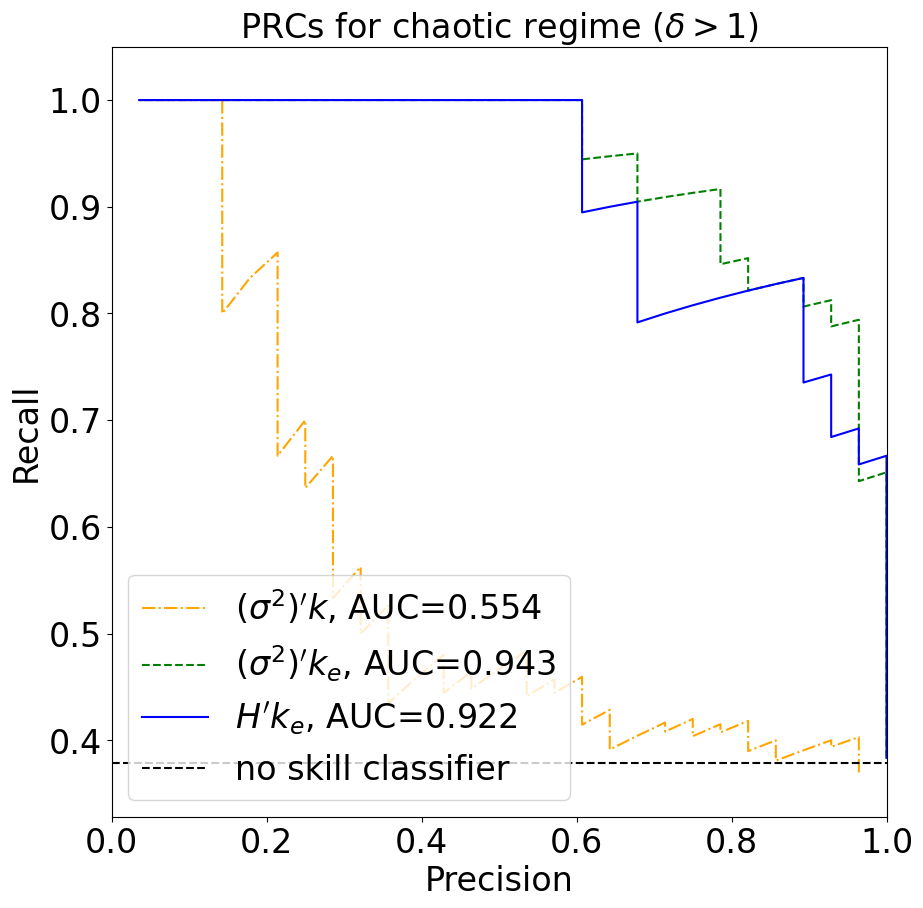

In [25]:
fs = 24
fig, ax = plt.subplots(1,1, figsize=(
        10, 10), sharey='row', sharex='col', facecolor='white')
truth = (dfcc['dc']>1)

x = dfcc['k']*dfcc['avgV']
fp = np.array([np.sum((x > cut) & ~truth) for cut in sorted(x)])
tp = np.array([np.sum((x > cut) & truth) for cut in sorted(x)])
tn = np.array([np.sum((x <= cut) & ~truth) for cut in sorted(x)])
fn = np.array([np.sum((x <= cut) & truth) for cut in sorted(x)])
prec = tp/(tp+fp)
reca = tp/(tp+fn)
AUC=-np.sum(prec[0:-1]*np.diff(reca)).round(3)
ax.plot(reca,prec,'-.',c='orange',label=f'$(\sigma^2)^\prime k$, {AUC=}')

x = dfcc['ke']*dfcc['avgV']
fp = np.array([np.sum((x > cut) & ~truth) for cut in sorted(x)])
tp = np.array([np.sum((x > cut) & truth) for cut in sorted(x)])
tn = np.array([np.sum((x <= cut) & ~truth) for cut in sorted(x)])
fn = np.array([np.sum((x <= cut) & truth) for cut in sorted(x)])
prec = tp/(tp+fp)
reca = tp/(tp+fn)
AUC=-np.nansum(prec[0:-1]*np.diff(reca)).round(3)
ax.plot(reca,prec,'--',c='green',label=f'$(\sigma^2)^\prime k_e$, {AUC=}')

x = dfcc['ke']*dfcc['avgH']
fp = np.array([np.sum((x > cut) & ~truth) for cut in sorted(x)])
tp = np.array([np.sum((x > cut) & truth) for cut in sorted(x)])
tn = np.array([np.sum((x <= cut) & ~truth) for cut in sorted(x)])
fn = np.array([np.sum((x <= cut) & truth) for cut in sorted(x)])
prec = tp/(tp+fp)
reca = tp/(tp+fn)
AUC=-np.nansum(prec[0:-1]*np.diff(reca)).round(3)
ax.plot(reca,prec,'-',c='blue',label=f'$H^\prime k_e$, {AUC=}')

noskill=np.sum(truth)/len(truth)
ax.hlines(noskill,0,1,color='k',linestyle='--',label="no skill classifier")

ax.set_xlim(0,1)
ax.set_ylim(noskill-0.05,1.05)

ax.set_ylabel('Recall', fontsize=fs)
ax.set_xlabel('Precision', fontsize=fs)
ax.legend(fontsize=fs,loc='lower left')
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_title('PRCs for chaotic regime ($\delta>1$)',fontsize=fs)
plt.savefig(f'figures/PRC_DC.pdf',bbox_inches='tight')
plt.savefig(f'figures/PRC_DC.png',bbox_inches='tight')
plt.show()

#### We also consider the ability of these parameters to predict the dynamical regime in terms of sensitivity.

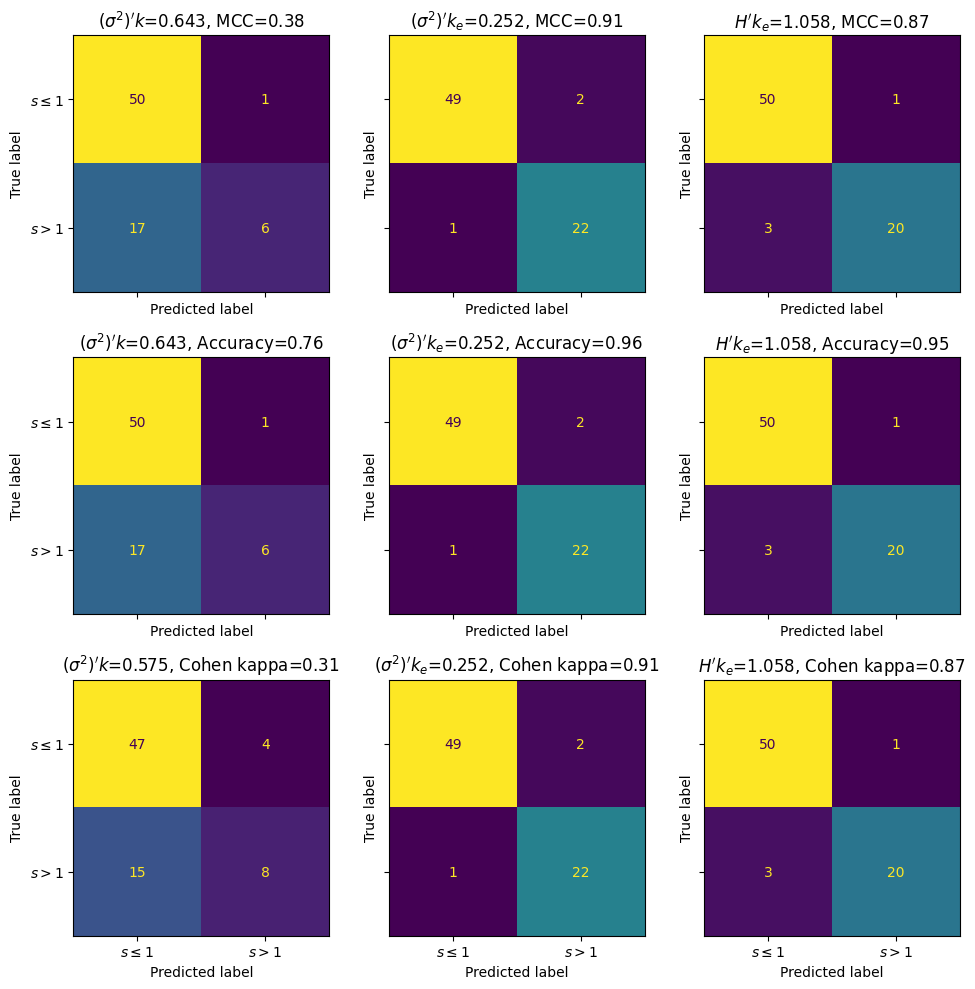

In [26]:
fs = 24

truth = (dfcc['s'] > 1)
fig, ax = plt.subplots(3,3, figsize=(
        10, 10), sharey='row', sharex='col', facecolor='white')

for row,method in enumerate(['MCC','Accuracy','Cohen kappa']):
    

    x = dfcc['k']*dfcc['avgV']
    preds,cut,score=optimize_cut(x,truth,method=method)
    confusion_matrix = metrics.confusion_matrix(truth, preds)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=['$s\leq 1$', '$s>1$'])
    cm_display.plot(ax=ax[row,0])
    cm_display.im_.colorbar.remove()
    mstr = '{'+str(np.round(m, 2))+'}'
    label = f'$(\sigma^2)^\prime k$={np.round(cut,3)}, {method}={np.round(score,2)}'
    ax[row,0].set_title(label)

    x = dfcc['ke']*dfcc['avgV']
    preds,cut,score=optimize_cut(x,truth,method=method)
    confusion_matrix = metrics.confusion_matrix(truth, preds)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=['$s\leq 1$', '$s>1$'])
    cm_display.plot(ax=ax[row,1])
    cm_display.im_.colorbar.remove()
    mstr = '{'+str(np.round(m, 2))+'}'
    label = f'$(\sigma^2)^\prime k_e$={np.round(cut,3)}, {method}={np.round(score,2)}'
    ax[row,1].set_title(label)

    x = dfcc['ke']*dfcc['avgH']
    preds,cut,score=optimize_cut(x,truth,method=method)
    confusion_matrix = metrics.confusion_matrix(truth, preds)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=['$s\leq 1$', '$s>1$'])
    cm_display.plot(ax=ax[row,2])
    cm_display.im_.colorbar.remove()
    mstr = '{'+str(np.round(m, 2))+'}'
    label = f'$H^\prime k_e$={np.round(cut,3)}, {method}={np.round(score,2)}'
    ax[row,2].set_title(label)

fig.tight_layout()
plt.savefig(f'figures/SensitivityConfusionOptimized_CC.pdf',bbox_inches='tight')
plt.savefig(f'figures/SensitivityConfusionOptimized_CC.png',bbox_inches='tight')
plt.show()

Notably, $(\sigma^2)^\prime k_e$ and $H^\prime k_e$ show very good agreement with the sensitivity.
#### We now build the ROCs for sensitivity prediction.

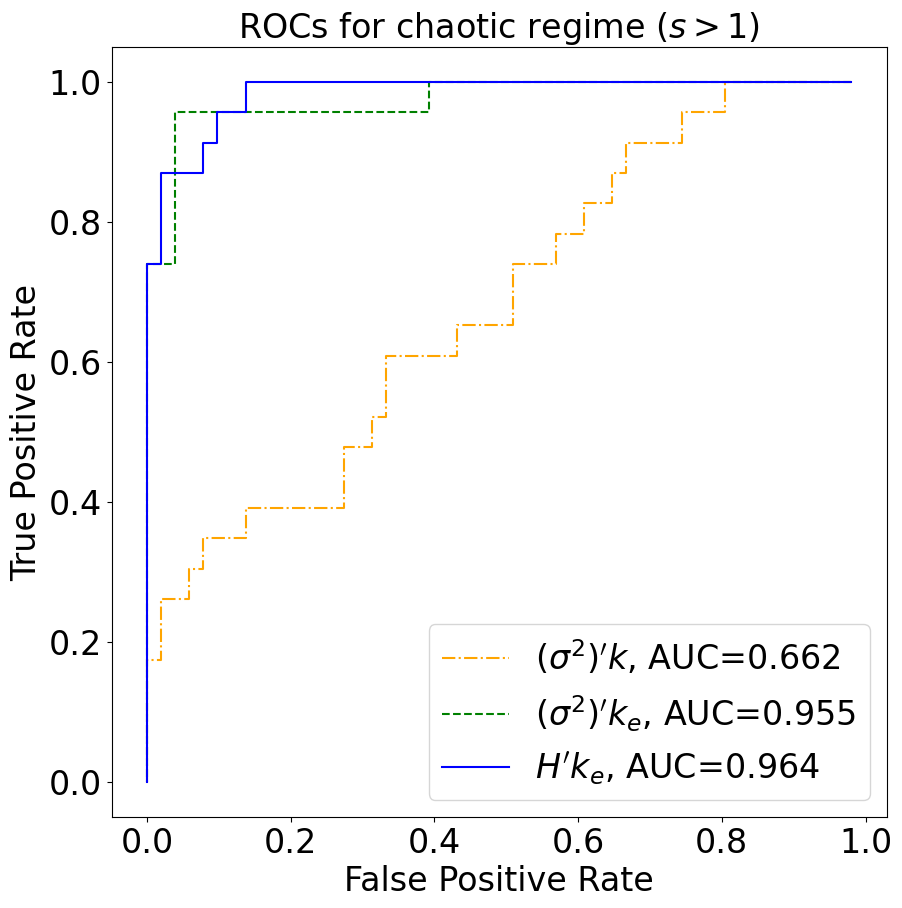

In [27]:
fs = 24
fig, ax = plt.subplots(1,1, figsize=(
        10, 10), sharey='row', sharex='col', facecolor='white')
truth = (dfcc['s']>1)

x = dfcc['k']*dfcc['avgV']
fp = np.array([np.sum((x > cut) & ~truth) for cut in sorted(x)])
tp = np.array([np.sum((x > cut) & truth) for cut in sorted(x)])
tn = np.array([np.sum((x <= cut) & ~truth) for cut in sorted(x)])
fn = np.array([np.sum((x <= cut) & truth) for cut in sorted(x)])
fpr = fp/(tn+fp)
tpr = tp/(tp+fn)
AUC=-np.sum(tpr[0:-1]*np.diff(fpr)).round(3)
ax.plot(fpr,tpr,'-.',c='orange',label=f'$(\sigma^2)^\prime k$, {AUC=}')

x = dfcc['ke']*dfcc['avgV']
fp = np.array([np.sum((x > cut) & ~truth) for cut in sorted(x)])
tp = np.array([np.sum((x > cut) & truth) for cut in sorted(x)])
tn = np.array([np.sum((x <= cut) & ~truth) for cut in sorted(x)])
fn = np.array([np.sum((x <= cut) & truth) for cut in sorted(x)])
fpr = fp/(tn+fp)
tpr = tp/(tp+fn)
AUC=-np.sum(tpr[0:-1]*np.diff(fpr)).round(3)
ax.plot(fpr,tpr,'--',c='green',label=f'$(\sigma^2)^\prime k_e$, {AUC=}')

x = dfcc['ke']*dfcc['avgH']
fp = np.array([np.sum((x > cut) & ~truth) for cut in sorted(x)])
tp = np.array([np.sum((x > cut) & truth) for cut in sorted(x)])
tn = np.array([np.sum((x <= cut) & ~truth) for cut in sorted(x)])
fn = np.array([np.sum((x <= cut) & truth) for cut in sorted(x)])
fpr = fp/(tn+fp)
tpr = tp/(tp+fn)
AUC=-np.sum(tpr[0:-1]*np.diff(fpr)).round(3)
ax.plot(fpr,tpr,'-',c='blue',label=f'$H^\prime k_e$, {AUC=}')

ax.set_ylabel('True Positive Rate', fontsize=fs)
ax.set_xlabel('False Positive Rate', fontsize=fs)
ax.legend(fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_title('ROCs for chaotic regime ($s>1$)',fontsize=fs)
plt.savefig(f'figures/ROC_S.pdf',bbox_inches='tight')
plt.savefig(f'figures/ROC_S.png',bbox_inches='tight')
plt.show()

#### We now build the PRCs for sensitivity prediction.

C:\Users\jcroz\AppData\Local\Temp\ipykernel_5880\3408119185.py:11: RuntimeWarning: invalid value encountered in divide
  prec = tp/(tp+fp)
C:\Users\jcroz\AppData\Local\Temp\ipykernel_5880\3408119185.py:21: RuntimeWarning: invalid value encountered in divide
  prec = tp/(tp+fp)
C:\Users\jcroz\AppData\Local\Temp\ipykernel_5880\3408119185.py:31: RuntimeWarning: invalid value encountered in divide
  prec = tp/(tp+fp)


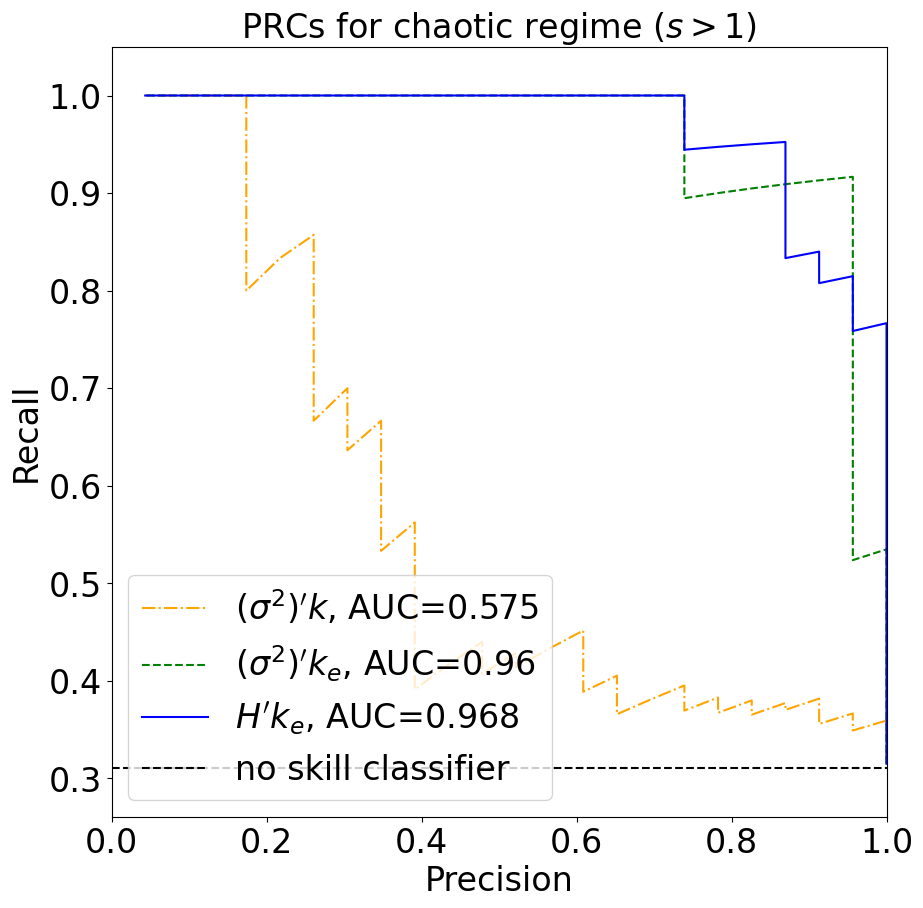

In [28]:
fs = 24
fig, ax = plt.subplots(1,1, figsize=(
        10, 10), sharey='row', sharex='col', facecolor='white')
truth = (dfcc['s']>1)

x = dfcc['k']*dfcc['avgV']
fp = np.array([np.sum((x > cut) & ~truth) for cut in sorted(x)])
tp = np.array([np.sum((x > cut) & truth) for cut in sorted(x)])
tn = np.array([np.sum((x <= cut) & ~truth) for cut in sorted(x)])
fn = np.array([np.sum((x <= cut) & truth) for cut in sorted(x)])
prec = tp/(tp+fp)
reca = tp/(tp+fn)
AUC=-np.sum(prec[0:-1]*np.diff(reca)).round(3)
ax.plot(reca,prec,'-.',c='orange',label=f'$(\sigma^2)^\prime k$, {AUC=}')

x = dfcc['ke']*dfcc['avgV']
fp = np.array([np.sum((x > cut) & ~truth) for cut in sorted(x)])
tp = np.array([np.sum((x > cut) & truth) for cut in sorted(x)])
tn = np.array([np.sum((x <= cut) & ~truth) for cut in sorted(x)])
fn = np.array([np.sum((x <= cut) & truth) for cut in sorted(x)])
prec = tp/(tp+fp)
reca = tp/(tp+fn)
AUC=-np.nansum(prec[0:-1]*np.diff(reca)).round(3)
ax.plot(reca,prec,'--',c='green',label=f'$(\sigma^2)^\prime k_e$, {AUC=}')

x = dfcc['ke']*dfcc['avgH']
fp = np.array([np.sum((x > cut) & ~truth) for cut in sorted(x)])
tp = np.array([np.sum((x > cut) & truth) for cut in sorted(x)])
tn = np.array([np.sum((x <= cut) & ~truth) for cut in sorted(x)])
fn = np.array([np.sum((x <= cut) & truth) for cut in sorted(x)])
prec = tp/(tp+fp)
reca = tp/(tp+fn)
AUC=-np.nansum(prec[0:-1]*np.diff(reca)).round(3)
ax.plot(reca,prec,'-',c='blue',label=f'$H^\prime k_e$, {AUC=}')

noskill=np.sum(truth)/len(truth)
ax.hlines(noskill,0,1,color='k',linestyle='--',label="no skill classifier")

ax.set_xlim(0,1)
ax.set_ylim(noskill-0.05,1.05)

ax.set_ylabel('Recall', fontsize=fs)
ax.set_xlabel('Precision', fontsize=fs)
ax.legend(fontsize=fs,loc='lower left')
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_title('PRCs for chaotic regime ($s>1$)',fontsize=fs)
plt.savefig(f'figures/PRC_S.pdf',bbox_inches='tight')
plt.savefig(f'figures/PRC_S.png',bbox_inches='tight')
plt.show()